In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jax_np
from jax import vmap as jax_vmap
from jax import grad as jax_grad
from jax import jit as jax_jit
from jax import random as jax_ran
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense, Relu

# Load data

In [2]:
dataset=np.load('data_ML_Nfreq100_Nbeta20_Nlambda20.npz',allow_pickle=True)
print(dataset.files)

['data', 'freq', 'params']


In [3]:
S= dataset['data']
Fr= dataset['freq']
parametre= dataset['params']



# I. For pre_processing we are going to use $S$ and $parametre$

###  1. Using $S$ for pre_processing

In [4]:
S=np.copy(S)
parametre=np.copy(parametre)

In [5]:
S.shape

(40000, 256, 3)

In [6]:
S=S[0:400,:,:]

In [7]:
S.shape

(400, 256, 3)

In [8]:
S[0,0,0]

(1.5750298860556053e-26+6.942531679368237e-27j)

/Users/ky266509/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


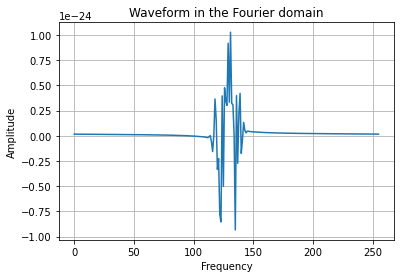

In [9]:
plt.plot(S[0,:,0])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Waveform in the Fourier domain')
plt.grid()


In [10]:
parameter=parametre[0:400,:]

In [11]:
parameter

array([[ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.14159265e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.48020473e+00],
       ...,
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.48020473e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  3.14159265e+00]])

####  a. Normalisation

- $ \overline{S_i}=\frac{S_i}{\rVert S_i \lVert_2},\quad \forall i \in \overline{0,400}$

In [12]:
# cette fonction normalise seulement une forme d'onde pour un canal "X","Y","Z"
def normalize(S,n,e):
# n nombre de FO, e nombre de canal
    
    return np.asarray([S[n,i,e]/np.linalg.norm(S[n,:,e]) for i in range(S.shape[1])])

# return un tableau contenant chaque forme d'onde normalisée

In [13]:
S1=normalize(S,10,0)
S1.shape

(256,)

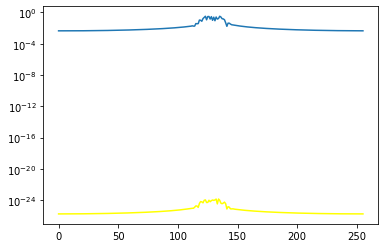

In [14]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S1))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')
#plt.semilogy(np.abs(S_canalXYZ[0,:,0]),color='red')

In [15]:
nb_fo=400 # nombre de FO utilisable pour l'apprentissage du réseau de neurones (400)

In [16]:
# cette fonction rassemble toutes les formes d'onde normalisée dans un seul tableau 
# n nombre de forme d'onde , e numéro du  canal ("X","Y","Z")
def norm(S):
    
    return (np.asarray([[normalize(S,n,e) for e in range (S.shape[-1])] for n in range(nb_fo)]))
# pour les n=400 premières formes d'ondes

In [17]:
S_bar=norm(S)


In [18]:
S_bar.shape

(400, 3, 256)

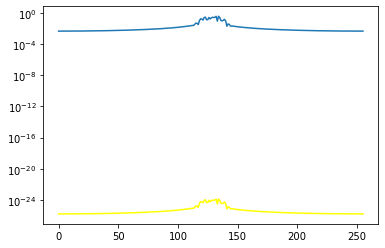

In [19]:
#plt.figure(figsize=(20,12))
plt.semilogy(np.abs(S_bar[0,0,:]))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')
#plt.sem

####  b. Génération de v.a uniforme 

- $ \tilde{S_{i,k}}= \alpha_k \times \overline{S_i},\quad \forall i \in [0,1,...,400] ,\quad k \in \overline{0,5}\quad avec \quad \alpha_k = \sqrt\frac{N\times\mathrm{X}_k}{2}\quad tq \quad \mathrm{X}_k \to \cup(1,20)$



- $ SNR=\frac{2}{N}\sum_{k=0}\frac{\lvert \tilde{S_{i,k}\rvert}{\sigma_k}$

In [20]:
Nb_ampli_diff=10 # réprésente le nombre d'amplitude différente
X=np.array([np.random.uniform(1,20,Nb_ampli_diff) for _ in range(nb_fo)])
X[10]

array([ 6.78396567, 12.78188306, 10.9777197 , 14.60652461,  2.63257119,
        1.83758684, 16.33060326, 16.03394057,  4.11374937,  4.84198921])

In [21]:
alpha=np.sqrt(256*X/2)
alpha

array([[35.65848331, 41.44728378, 42.69938556, ..., 37.93441797,
        44.7913684 , 42.35002355],
       [35.62556127, 23.51099593, 29.65910531, ..., 30.51784174,
        31.47418476, 26.031496  ],
       [35.75462975, 17.3105075 , 29.19626664, ..., 49.27167129,
        50.5264662 , 27.70306348],
       ...,
       [43.09882408, 29.21908257, 12.75466308, ..., 47.33728932,
        18.03797429, 25.48062273],
       [22.16523663, 36.21991033, 30.91953334, ..., 20.62454427,
        42.08268539, 47.12426821],
       [42.52913138, 33.72030031, 45.39439825, ..., 45.74326803,
        15.32732504, 22.766734  ]])

In [22]:
# multiplication de X par chaque FO
def amplitude(S,n):
    
    return np.asarray([S[n,:,:]*i for i in alpha[n]])

In [23]:
# cette fonction retourne les 5 amplitudes différentes de chaque FO
def amp(S):
     
    return (np.asarray([amplitude(S,n) for n in range(nb_fo)])).reshape((-1,3,256))
# chaque FO retourne 5 sous formes d'onde d'amplitude différentes chacune ayant 2827 fréquences 





In [24]:
S_tilde=amp(S_bar)

In [25]:
S_tilde.shape

(4000, 3, 256)

###  2. Using $parametre $ for pre_processing

####  a. Parameters used for learning

-  Amplitude $h_0$
-  Latitude Ecliptic $\beta$
-  Ecliptic Longitude $\lambda$

In [26]:
amplitude=parametre[:,0] # amplitude
beta=parametre[:,6] # bêta
lamb=parametre[:,7] # lambda
#parameters=[]
#zz=np.concatenate((amplitude[0:2],beta[0:2]))
parameters=np.asarray([(i,j,k)for i,j,k in zip(amplitude,beta,lamb)] )

parameters.shape



(40000, 3)

In [27]:
parameters

array([[ 1.00000000e-22,  0.00000000e+00, -3.14159265e+00],
       [ 1.00000000e-22,  0.00000000e+00, -2.81089869e+00],
       [ 1.00000000e-22,  0.00000000e+00, -2.48020473e+00],
       ...,
       [ 1.00000000e-22,  1.57079633e+00,  2.48020473e+00],
       [ 1.00000000e-22,  1.57079633e+00,  2.81089869e+00],
       [ 1.00000000e-22,  1.57079633e+00,  3.14159265e+00]])

-  $ \overline{h}=[h_i]=\frac{h_0}{\rVert S_i \lVert_2},\forall i \quad\text{allant de 0 à nb_fo}$

 -  $\tilde{h}=[h_i]\times\alpha_j ,\forall i \in  \overline{0,nb}\quad et\quad j \in\overline{0,N}\quad avec \quad  \mathrm{X} \to \cup(1,20) $

$$
 \forall i \in [1,2,..400],\begin{array}{|c|c|c|c|c|}
\hline
\beta & \lambda & \overline{h} & \tilde{h}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte1}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte2}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte3}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte4}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte5}\\
\hline
\end{array}
$$




In [28]:
def ParametersAmpli(data): # c canal utilisé
    h_bar=[parameters[i,0]/np.linalg.norm(data[i,:,:]) for i in range(nb_fo)]
    h_tilde=np.asarray([[h_bar[j]*i for i in alpha[j]]for j in range(nb_fo)])
    lam=np.array([[u]*Nb_ampli_diff for u in lamb ])
    bet=np.array([[v]*Nb_ampli_diff for v in beta])
    return h_tilde,bet,lam



In [29]:
h_tilde,bet,lam=ParametersAmpli(S) # une question à posé ici : jerôme

In [30]:
final_params=np.asarray([[(i,j,k)for i,j,k in zip(h_tilde[n,:],bet[n,:],lam[n,:])] for n in range(nb_fo)])


In [31]:
final_params.shape

(400, 10, 3)

In [32]:
final_params=np.reshape(final_params,(-1,3))

In [33]:
final_params.shape

(4000, 3)

####  b. This function allows to put on the same scale our parameters (Target)

In [34]:
h_mean=np.mean(final_params[:,0])
h_max_mean=np.max(np.abs(final_params[:,0]-h_mean))

beta_mean=np.mean(final_params[:,1])
beta_max_mean=np.max(np.abs(final_params[:,1]-beta_mean))

lam_mean=np.mean(final_params[:,2])
lam_max_mean=np.max(np.abs(final_params[:,2]-lam_mean))



In [35]:
def maximum_absolute_scaling(param):
    n=3
    h,beta,lambd =[],[],[]
    for i in range(n):
        for j in range(len(param)):
            if i==0:
                H=(param[j,i]-h_mean)/h_max_mean
                h.append(H)
            elif i==1:
                Beta=(param[j,i]-beta_mean)/beta_max_mean
                beta.append(Beta)
            
            else:
                
                Lambd=(param[j,i]-lam_mean)/lam_max_mean
                lambd.append(Lambd)
                                                              
                                                              
    return h,beta,lambd
    

In [36]:
h,b,l=maximum_absolute_scaling(final_params)

In [37]:
par=np.asarray([(i,j,k)for i,j,k in zip(h,b,l)])

In [38]:
par

array([[-0.03661814, -0.59291389, -1.        ],
       [ 0.19356603, -0.59291389, -1.        ],
       [ 0.24335424, -0.59291389, -1.        ],
       ...,
       [ 0.66567577,  1.        ,  1.        ],
       [-0.74410781,  1.        ,  1.        ],
       [-0.39929007,  1.        ,  1.        ]])

In [39]:
par.shape

(4000, 3)

#  II. Learning

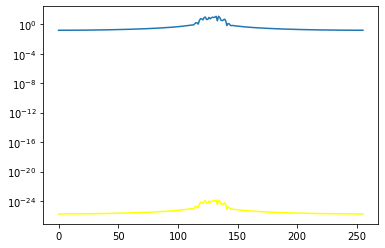

In [40]:
plt.semilogy(np.abs(S_tilde[0,0,:]))
plt.semilogy(np.abs(S[0,:,0]),color='yellow')

#### Ajout de bruit au signal

In [41]:
S_canalXYZ=S_tilde  # donnée non bruitée

In [42]:
noise=[[np.random.normal(0,1,S_tilde.shape[2])+ 1j* np.random.normal(0,1,S_tilde.shape[2]) for _ in range(S_tilde.shape[1])]for _ in range(S_tilde.shape[0])]

In [43]:
n=np.array(noise)

In [44]:
n.shape

(4000, 3, 256)

In [45]:
S_tilde_noise=S_tilde+ n

In [46]:
S_canalXYZ[0,0,0]

(0.14575756134082865+0.06424808164436549j)

Text(0.5, 1.0, 'SNR =9.933808 ')

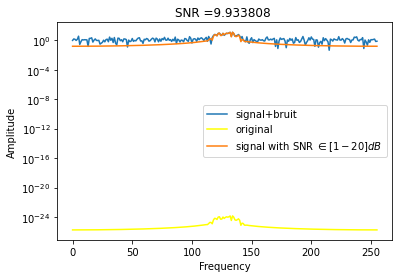

In [47]:
#plt.figure(figsize=(10,8))
plt.semilogy(np.abs(S_tilde_noise[0,0,:]),label='signal+bruit')
plt.semilogy(np.abs(S[0,:,0]),color='yellow',label='original')
plt.semilogy(np.abs(S_tilde[0,0,:]),label=r'signal with SNR $\in [1-20]dB$ ')
plt.ylabel("Amplitude")
plt.xlabel("Frequency")
#plt.semilogy(np.abs(S_tilde_noise[0,0,:]),color='red',label='noise')
plt.legend()
plt.title(r'SNR =%lf '%(X[0,0]),)

###  1. Split data

In [48]:
# we can use par or final_data to do the splitting
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(S_canalXYZ,par,test_size=0.20,random_state=42)

In [49]:
X_train.shape

(3200, 3, 256)

In [50]:
X_train[0,:,0]

array([-0.09659216-0.0279147j ,  0.01643633+0.11888183j,
        0.08628281-0.08913073j])

In [51]:
X_trainR=np.real(X_train[:,:,:]) # 1600 échantillons 
X_trainI=np.imag(X_train[:,:,:])# 1600 échantillons 
X_Tr=np.concatenate((X_trainR,X_trainI),axis=1)



In [52]:
X_testR=np.real(X_test[:,:,:]) # 400 échantillons 
X_testI=np.imag(X_test[:,:,:])# 400 échantillons 
X_Te=np.concatenate((X_testR,X_testI),axis=1)

X_Te.shape

(800, 6, 256)

In [53]:
Y_test.shape

(800, 3)

In [54]:
X_Tr[0,:,0]

array([-0.09659216,  0.01643633,  0.08628281, -0.0279147 ,  0.11888183,
       -0.08913073])

In [55]:
X_Tr.shape

(3200, 6, 256)

In [56]:
Y_train.shape

(3200, 3)

###  2. Architecture réseau

####  a. Initialisation des paramètres du réseau (Hyperparamètres)

- Les paramètres du réseau sont spécifiés par une liste python de longueur $N_{\rm layers}$.
- Chaque élément de la liste est un tuple à deux éléments stokant les paramètres des $n_{\rm i}$ neurones de la couche $i^{\rm th}$.
  - Le premier élément de tuple donne des valeurs de paramètres sur les poids $w_{\rm i,i-1}$ , stockés comme un ndarray de la forme ($n_{\rm i}$,$n_{\rm i-1}$).
  - Le deuxième élément de tuple donne des valeurs de paramètres sur les biais $b_{\rm i}$, stokés comme un ndarray de la forme ($n_{\rm i}$, ).

In [57]:
from jax.nn.initializers import glorot_normal,normal
def initialize_network_layer(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys=jax_ran.split(key,len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_network_params(m, n,key):
        w_key,b_key=jax_ran.split(key)
        w_init=glorot_normal()
        b_init=normal()
        if (m==sizes[0]).any():
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m.shape[0],m.shape[1]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        elif n==sizes[-1]:
        
            ran_weigths=w_init(w_key,(n,m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n,))
        else:
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        return ran_weigths,ran_biases
    
    return [initialize_network_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]



####  b. Construction du réseau de neurone

In [58]:
def network_layer_sizes(n_features,n_targets,n_layers,n_neurons_per_layer):
    dense_layer_sizes=[np.asarray(n_neurons_per_layer).reshape(-1,1)]*n_layers
    layer_sizes=[n_features,*dense_layer_sizes,n_targets]
    return layer_sizes



key=jax_ran.PRNGKey(0)
num_features, num_targets =X_Tr[0,:,:], 3          
num_layers, num_neurons_per_layer = 3, 20   # MLP à 3  couches cachées (10 units )

layer_sizes =network_layer_sizes(
   num_features, num_targets, num_layers, num_neurons_per_layer)


# Return a list of tuples of layer weights
params=initialize_network_layer(layer_sizes ,key)
layer_sizes 

[array([[-0.09659216, -0.09624889, -0.09590553, ..., -0.09816655,
         -0.09782179, -0.09747726],
        [ 0.01643633,  0.01498316,  0.01352994, ...,  0.02099033,
          0.01952691,  0.01806475],
        [ 0.08628281,  0.08737047,  0.08845809, ...,  0.08340964,
          0.08450596,  0.08560126],
        [-0.0279147 , -0.02909874, -0.03028312, ..., -0.02443007,
         -0.02562187, -0.02681294],
        [ 0.11888183,  0.11906771,  0.11925379, ...,  0.11895511,
          0.11914266,  0.11933025],
        [-0.08913073, -0.08805733, -0.08698377, ..., -0.09290815,
         -0.09182813, -0.09074893]]),
 array([[20]]),
 array([[20]]),
 array([[20]]),
 3]

In [59]:
for w,b in params[:-1]:
    print(w.shape,b.shape)

(20, 20, 6, 256) (20, 20)
(20, 20, 20, 20) (20, 20)
(20, 20, 20, 20) (20, 20)


In [60]:
W,B = params[-1]
print(W.shape,B.shape)

(3, 20, 20) (3,)


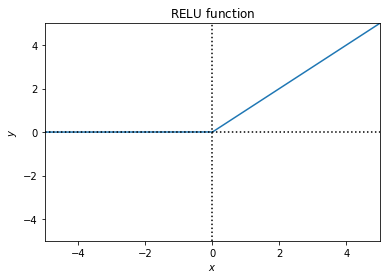

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from jax.nn import relu

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-5, 5)
ylim = ax.set_ylim(-5, 5)
_x = np.linspace(-5, 5, 1000)
__=ax.plot(_x, relu(_x))
xlabel = ax.set_xlabel(r'$x$')
ylabel = ax.set_ylabel(r'$y$')
title = ax.set_title(r'${\rm RELU\ function}$')
__=ax.plot(_x, np.zeros_like(_x), ':', color='k')
__=ax.plot(np.zeros_like(_x), _x, ':', color='k')

###  3. Feedforward function 

In [62]:
def predict(params,in_array):
    """ Chaque neurone est appliqué à la fonction d'activation y=w*x+b,
     seulement la dernière couche (couche de sortie) qui n'utilise pas de cette fonction d'activation (régression) 
     utilisation de la fonction identité
     
     Paramètres de la fonction:
     --------------------------------
       params: list de tuple 
            paramètre du réseau , avec une liste d'élément par couche (w,b)
       in_array: ndarray 
            shape de la forme (batch_size, n_features)
    
     Returns
     -------------------------------
        preds: ndarray
             ndarray dont le shape est (batch_size, n_targets)
     
     """
    
    activations = in_array
    
    # Boucle itérative sur chaque couche dense exceptée la dernière
    
    for w, b in params[:-1]:
        outputs = jax_np.einsum('mjt,ikjt ->mik',activations,w)+b[np.newaxis,:,:]  # Application de la transformation linéaire
        activations = relu(outputs)  #  apply nonlinear activation
        
    #  Now for the final layer
    w_final, b_final = params[-1] 
    final_outputs = jax_np.einsum('mik,sik ->ms',activations,w_final) + b_final[np.newaxis,:] 
    return final_outputs  # Final layer is just w*x + b with no activation

In [63]:
pred=predict(params,X_Tr)

In [64]:
pred.shape

(3200, 3)

###  4. Loss function

In [65]:
def mse_loss(params, in_array, targets):
    pred = predict(params,in_array)
    diff_Ampli = [(pred[i,0]-targets[i,0])**2/pred.shape[0] for i in range(pred.shape[0])]
    diff_Beta = [(pred[j,1]-targets[j,1])**2/pred.shape[0] for j in range(pred.shape[0])]
    diff_lambda = [(pred[k,2]-targets[k,2])**2/pred.shape[0] for k in range(pred.shape[0])]
    error=sum(diff_Ampli) +sum(diff_Beta)+sum(diff_lambda)
    return error

In [66]:
mse_loss(params, X_Tr, Y_train)

DeviceArray(0.742679, dtype=float32)

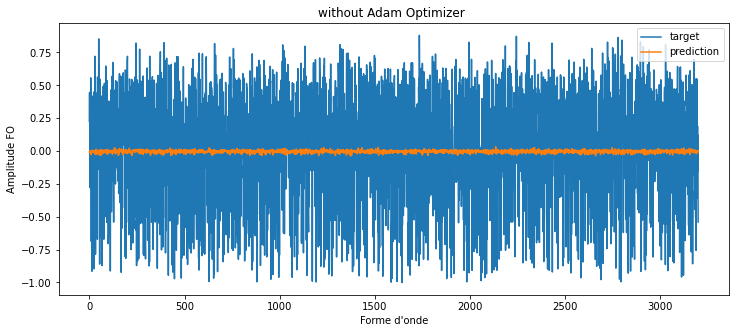

In [67]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

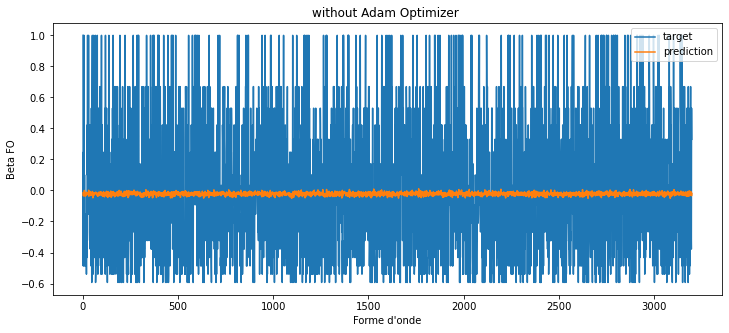

In [68]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred[:,1],label='prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

### 5. Backpropagation 

In [69]:
num_epochs =1000
batch_size=200
num_batches=8

In [70]:

# Defining an optimizer in Jax
learning_rate= 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params) # init avce les paramètre du réseau

# Define a compiled update step
@jax_jit
def update(i, opt_state, x, y):
    p = get_params(opt_state)
    g = jax_grad(mse_loss)(p, x, y)
    loss=mse_loss(p,x,y)
    return opt_update(i, g, opt_state),loss





###  6. Training Loop 

In [71]:
from jax import lax
@jax_jit
def run_epoch(opt_state,X_train,Y_train):
    
    def batch_opt(i, opt_state):
        #Los=[]
        j = i // num_batches
        batch_x = lax.dynamic_slice_in_dim(X_train, j * batch_size, batch_size)
        batch_y = lax.dynamic_slice_in_dim(Y_train, j * batch_size, batch_size)
    #  fonction définissant la loss à minimiser, son gradient g pour l'état opt_state de la minimisation
        loss = lambda params: mse_loss(params, batch_x, batch_y)
        g = jax_grad(loss)(get_params(opt_state))
        return opt_update(i, g, opt_state)
    return lax.fori_loop(0, num_batches, batch_opt, opt_state) #num_batches est le nb de batches et batch_size leur taille
# en sortie, opt_state pour une époque

In [72]:
#net_params=get_params(opt)

In [73]:
import time
def run_func(opt_state,X,Y):
    Los=[]
# Adam optimisation
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):
            j = epoch // num_batches
            batch_X = lax.dynamic_slice_in_dim(X, j * batch_size, batch_size)
            batch_Y = lax.dynamic_slice_in_dim(Y, j * batch_size, batch_size)
            opt_state ,loss = update(epoch, opt_state,batch_X,batch_Y)
            batch_time = time.time() - start_time
            Los.append(loss)
            print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))
    return get_params(opt_state),Los
#net_params = get_params(opt_state)

In [74]:
net_params,Loss=run_func(opt_state,X_Tr,Y_train)

Batch 0 | T: 34.52 | MSE: 0.77 |
Batch 1 | T: 34.57 | MSE: 0.67 |
Batch 2 | T: 34.60 | MSE: 0.46 |
Batch 3 | T: 34.64 | MSE: 0.45 |
Batch 4 | T: 34.67 | MSE: 0.86 |
Batch 5 | T: 34.71 | MSE: 0.41 |
Batch 6 | T: 34.73 | MSE: 0.48 |
Batch 7 | T: 34.77 | MSE: 0.43 |
Batch 0 | T: 34.83 | MSE: 0.39 |
Batch 1 | T: 34.87 | MSE: 0.35 |
Batch 2 | T: 34.91 | MSE: 0.31 |
Batch 3 | T: 34.95 | MSE: 0.29 |
Batch 4 | T: 34.99 | MSE: 0.26 |
Batch 5 | T: 35.03 | MSE: 0.23 |
Batch 6 | T: 35.07 | MSE: 0.21 |
Batch 7 | T: 35.10 | MSE: 0.20 |
Batch 0 | T: 35.13 | MSE: 0.20 |
Batch 1 | T: 35.15 | MSE: 0.18 |
Batch 2 | T: 35.18 | MSE: 0.17 |
Batch 3 | T: 35.23 | MSE: 0.16 |
Batch 4 | T: 35.27 | MSE: 0.16 |
Batch 5 | T: 35.30 | MSE: 0.15 |
Batch 6 | T: 35.33 | MSE: 0.15 |
Batch 7 | T: 35.37 | MSE: 0.14 |
Batch 0 | T: 35.40 | MSE: 0.14 |
Batch 1 | T: 35.45 | MSE: 0.13 |
Batch 2 | T: 35.52 | MSE: 0.13 |
Batch 3 | T: 35.59 | MSE: 0.12 |
Batch 4 | T: 35.63 | MSE: 0.12 |
Batch 5 | T: 35.70 | MSE: 0.12 |
Batch 6 | 

Batch 0 | T: 42.79 | MSE: 0.21 |
Batch 1 | T: 42.83 | MSE: 0.16 |
Batch 2 | T: 42.85 | MSE: 0.12 |
Batch 3 | T: 42.88 | MSE: 0.11 |
Batch 4 | T: 42.91 | MSE: 0.10 |
Batch 5 | T: 42.94 | MSE: 0.10 |
Batch 6 | T: 42.97 | MSE: 0.09 |
Batch 7 | T: 43.00 | MSE: 0.08 |
Batch 0 | T: 43.03 | MSE: 0.08 |
Batch 1 | T: 43.06 | MSE: 0.08 |
Batch 2 | T: 43.09 | MSE: 0.07 |
Batch 3 | T: 43.12 | MSE: 0.07 |
Batch 4 | T: 43.15 | MSE: 0.07 |
Batch 5 | T: 43.17 | MSE: 0.06 |
Batch 6 | T: 43.20 | MSE: 0.06 |
Batch 7 | T: 43.23 | MSE: 0.06 |
Batch 0 | T: 43.27 | MSE: 0.06 |
Batch 1 | T: 43.30 | MSE: 0.05 |
Batch 2 | T: 43.32 | MSE: 0.05 |
Batch 3 | T: 43.35 | MSE: 0.05 |
Batch 4 | T: 43.38 | MSE: 0.05 |
Batch 5 | T: 43.41 | MSE: 0.05 |
Batch 6 | T: 43.44 | MSE: 0.05 |
Batch 7 | T: 43.48 | MSE: 0.05 |
Batch 0 | T: 43.50 | MSE: 0.05 |
Batch 1 | T: 43.53 | MSE: 0.04 |
Batch 2 | T: 43.56 | MSE: 0.04 |
Batch 3 | T: 43.59 | MSE: 0.04 |
Batch 4 | T: 43.61 | MSE: 0.04 |
Batch 5 | T: 43.65 | MSE: 0.04 |
Batch 6 | 

Batch 5 | T: 50.23 | MSE: 0.05 |
Batch 6 | T: 50.27 | MSE: 0.05 |
Batch 7 | T: 50.30 | MSE: 0.05 |
Batch 0 | T: 50.33 | MSE: 0.25 |
Batch 1 | T: 50.36 | MSE: 0.20 |
Batch 2 | T: 50.39 | MSE: 0.17 |
Batch 3 | T: 50.41 | MSE: 0.15 |
Batch 4 | T: 50.44 | MSE: 0.13 |
Batch 5 | T: 50.47 | MSE: 0.13 |
Batch 6 | T: 50.51 | MSE: 0.12 |
Batch 7 | T: 50.53 | MSE: 0.12 |
Batch 0 | T: 50.56 | MSE: 0.12 |
Batch 1 | T: 50.59 | MSE: 0.11 |
Batch 2 | T: 50.62 | MSE: 0.10 |
Batch 3 | T: 50.64 | MSE: 0.10 |
Batch 4 | T: 50.67 | MSE: 0.10 |
Batch 5 | T: 50.70 | MSE: 0.10 |
Batch 6 | T: 50.74 | MSE: 0.09 |
Batch 7 | T: 50.77 | MSE: 0.09 |
Batch 0 | T: 50.80 | MSE: 0.09 |
Batch 1 | T: 50.82 | MSE: 0.09 |
Batch 2 | T: 50.85 | MSE: 0.09 |
Batch 3 | T: 50.88 | MSE: 0.08 |
Batch 4 | T: 50.91 | MSE: 0.08 |
Batch 5 | T: 50.94 | MSE: 0.08 |
Batch 6 | T: 50.98 | MSE: 0.08 |
Batch 7 | T: 51.01 | MSE: 0.08 |
Batch 0 | T: 51.04 | MSE: 0.07 |
Batch 1 | T: 51.06 | MSE: 0.07 |
Batch 2 | T: 51.09 | MSE: 0.07 |
Batch 3 | 

Batch 6 | T: 58.68 | MSE: 0.03 |
Batch 7 | T: 59.51 | MSE: 0.03 |
Batch 0 | T: 59.57 | MSE: 0.03 |
Batch 1 | T: 59.61 | MSE: 0.03 |
Batch 2 | T: 60.19 | MSE: 0.03 |
Batch 3 | T: 60.44 | MSE: 0.03 |
Batch 4 | T: 60.49 | MSE: 0.03 |
Batch 5 | T: 60.67 | MSE: 0.03 |
Batch 6 | T: 61.28 | MSE: 0.03 |
Batch 7 | T: 61.37 | MSE: 0.03 |
Batch 0 | T: 61.42 | MSE: 0.17 |
Batch 1 | T: 61.47 | MSE: 0.13 |
Batch 2 | T: 61.51 | MSE: 0.11 |
Batch 3 | T: 61.57 | MSE: 0.11 |
Batch 4 | T: 61.62 | MSE: 0.10 |
Batch 5 | T: 61.66 | MSE: 0.09 |
Batch 6 | T: 61.70 | MSE: 0.08 |
Batch 7 | T: 61.74 | MSE: 0.08 |
Batch 0 | T: 61.77 | MSE: 0.08 |
Batch 1 | T: 61.82 | MSE: 0.08 |
Batch 2 | T: 61.85 | MSE: 0.07 |
Batch 3 | T: 61.89 | MSE: 0.07 |
Batch 4 | T: 61.93 | MSE: 0.07 |
Batch 5 | T: 61.98 | MSE: 0.07 |
Batch 6 | T: 62.11 | MSE: 0.07 |
Batch 7 | T: 62.16 | MSE: 0.07 |
Batch 0 | T: 62.20 | MSE: 0.07 |
Batch 1 | T: 62.24 | MSE: 0.07 |
Batch 2 | T: 62.29 | MSE: 0.06 |
Batch 3 | T: 62.33 | MSE: 0.06 |
Batch 4 | 

Batch 7 | T: 76.43 | MSE: 0.04 |
Batch 0 | T: 76.52 | MSE: 0.04 |
Batch 1 | T: 76.58 | MSE: 0.04 |
Batch 2 | T: 76.64 | MSE: 0.04 |
Batch 3 | T: 76.74 | MSE: 0.04 |
Batch 4 | T: 76.80 | MSE: 0.04 |
Batch 5 | T: 76.84 | MSE: 0.04 |
Batch 6 | T: 76.87 | MSE: 0.04 |
Batch 7 | T: 76.91 | MSE: 0.04 |
Batch 0 | T: 76.95 | MSE: 0.04 |
Batch 1 | T: 77.00 | MSE: 0.04 |
Batch 2 | T: 77.07 | MSE: 0.04 |
Batch 3 | T: 77.12 | MSE: 0.04 |
Batch 4 | T: 77.17 | MSE: 0.04 |
Batch 5 | T: 77.22 | MSE: 0.04 |
Batch 6 | T: 77.26 | MSE: 0.04 |
Batch 7 | T: 77.29 | MSE: 0.04 |
Batch 0 | T: 77.37 | MSE: 0.04 |
Batch 1 | T: 77.44 | MSE: 0.04 |
Batch 2 | T: 77.48 | MSE: 0.04 |
Batch 3 | T: 77.56 | MSE: 0.04 |
Batch 4 | T: 77.62 | MSE: 0.04 |
Batch 5 | T: 77.71 | MSE: 0.04 |
Batch 6 | T: 77.77 | MSE: 0.04 |
Batch 7 | T: 77.89 | MSE: 0.04 |
Batch 0 | T: 77.96 | MSE: 0.04 |
Batch 1 | T: 78.01 | MSE: 0.04 |
Batch 2 | T: 78.14 | MSE: 0.04 |
Batch 3 | T: 78.18 | MSE: 0.04 |
Batch 4 | T: 78.21 | MSE: 0.03 |
Batch 5 | 

Batch 0 | T: 86.40 | MSE: 0.03 |
Batch 1 | T: 86.43 | MSE: 0.03 |
Batch 2 | T: 86.47 | MSE: 0.03 |
Batch 3 | T: 86.51 | MSE: 0.03 |
Batch 4 | T: 86.55 | MSE: 0.03 |
Batch 5 | T: 86.58 | MSE: 0.03 |
Batch 6 | T: 86.62 | MSE: 0.03 |
Batch 7 | T: 86.66 | MSE: 0.03 |
Batch 0 | T: 86.69 | MSE: 0.03 |
Batch 1 | T: 86.73 | MSE: 0.03 |
Batch 2 | T: 86.76 | MSE: 0.03 |
Batch 3 | T: 86.80 | MSE: 0.03 |
Batch 4 | T: 86.82 | MSE: 0.03 |
Batch 5 | T: 86.86 | MSE: 0.03 |
Batch 6 | T: 86.90 | MSE: 0.03 |
Batch 7 | T: 86.93 | MSE: 0.03 |
Batch 0 | T: 86.97 | MSE: 0.03 |
Batch 1 | T: 87.02 | MSE: 0.03 |
Batch 2 | T: 87.11 | MSE: 0.03 |
Batch 3 | T: 87.18 | MSE: 0.03 |
Batch 4 | T: 87.25 | MSE: 0.03 |
Batch 5 | T: 87.28 | MSE: 0.03 |
Batch 6 | T: 87.32 | MSE: 0.03 |
Batch 7 | T: 87.36 | MSE: 0.03 |
Batch 0 | T: 87.40 | MSE: 0.03 |
Batch 1 | T: 87.43 | MSE: 0.03 |
Batch 2 | T: 87.46 | MSE: 0.03 |
Batch 3 | T: 87.49 | MSE: 0.03 |
Batch 4 | T: 87.52 | MSE: 0.03 |
Batch 5 | T: 87.55 | MSE: 0.03 |
Batch 6 | 

Batch 1 | T: 95.00 | MSE: 0.03 |
Batch 2 | T: 95.06 | MSE: 0.03 |
Batch 3 | T: 95.11 | MSE: 0.03 |
Batch 4 | T: 95.17 | MSE: 0.03 |
Batch 5 | T: 95.22 | MSE: 0.03 |
Batch 6 | T: 95.27 | MSE: 0.03 |
Batch 7 | T: 95.31 | MSE: 0.03 |
Batch 0 | T: 95.34 | MSE: 0.03 |
Batch 1 | T: 95.37 | MSE: 0.03 |
Batch 2 | T: 95.41 | MSE: 0.03 |
Batch 3 | T: 95.43 | MSE: 0.03 |
Batch 4 | T: 95.47 | MSE: 0.03 |
Batch 5 | T: 95.50 | MSE: 0.03 |
Batch 6 | T: 95.53 | MSE: 0.03 |
Batch 7 | T: 95.57 | MSE: 0.03 |
Batch 0 | T: 95.60 | MSE: 0.03 |
Batch 1 | T: 95.63 | MSE: 0.03 |
Batch 2 | T: 95.66 | MSE: 0.03 |
Batch 3 | T: 95.69 | MSE: 0.03 |
Batch 4 | T: 95.73 | MSE: 0.03 |
Batch 5 | T: 95.76 | MSE: 0.03 |
Batch 6 | T: 95.79 | MSE: 0.03 |
Batch 7 | T: 95.82 | MSE: 0.03 |
Batch 0 | T: 95.86 | MSE: 0.03 |
Batch 1 | T: 95.89 | MSE: 0.03 |
Batch 2 | T: 95.92 | MSE: 0.03 |
Batch 3 | T: 95.96 | MSE: 0.03 |
Batch 4 | T: 96.00 | MSE: 0.03 |
Batch 5 | T: 96.03 | MSE: 0.03 |
Batch 6 | T: 96.07 | MSE: 0.03 |
Batch 7 | 

Batch 0 | T: 102.79 | MSE: 0.02 |
Batch 1 | T: 102.82 | MSE: 0.02 |
Batch 2 | T: 102.85 | MSE: 0.02 |
Batch 3 | T: 102.88 | MSE: 0.02 |
Batch 4 | T: 102.91 | MSE: 0.02 |
Batch 5 | T: 102.94 | MSE: 0.02 |
Batch 6 | T: 102.98 | MSE: 0.02 |
Batch 7 | T: 103.02 | MSE: 0.02 |
Batch 0 | T: 103.05 | MSE: 0.02 |
Batch 1 | T: 103.09 | MSE: 0.02 |
Batch 2 | T: 103.13 | MSE: 0.02 |
Batch 3 | T: 103.17 | MSE: 0.02 |
Batch 4 | T: 103.21 | MSE: 0.02 |
Batch 5 | T: 103.25 | MSE: 0.02 |
Batch 6 | T: 103.28 | MSE: 0.02 |
Batch 7 | T: 103.32 | MSE: 0.02 |
Batch 0 | T: 103.35 | MSE: 0.02 |
Batch 1 | T: 103.38 | MSE: 0.02 |
Batch 2 | T: 103.42 | MSE: 0.02 |
Batch 3 | T: 103.45 | MSE: 0.02 |
Batch 4 | T: 103.49 | MSE: 0.02 |
Batch 5 | T: 103.52 | MSE: 0.02 |
Batch 6 | T: 103.56 | MSE: 0.02 |
Batch 7 | T: 103.59 | MSE: 0.02 |
Batch 0 | T: 103.62 | MSE: 0.02 |
Batch 1 | T: 103.65 | MSE: 0.02 |
Batch 2 | T: 103.68 | MSE: 0.02 |
Batch 3 | T: 103.72 | MSE: 0.02 |
Batch 4 | T: 103.75 | MSE: 0.02 |
Batch 5 | T: 1

Batch 4 | T: 111.51 | MSE: 0.02 |
Batch 5 | T: 111.57 | MSE: 0.02 |
Batch 6 | T: 111.61 | MSE: 0.02 |
Batch 7 | T: 111.64 | MSE: 0.02 |
Batch 0 | T: 111.67 | MSE: 0.02 |
Batch 1 | T: 111.70 | MSE: 0.02 |
Batch 2 | T: 111.72 | MSE: 0.02 |
Batch 3 | T: 111.76 | MSE: 0.02 |
Batch 4 | T: 111.80 | MSE: 0.02 |
Batch 5 | T: 111.83 | MSE: 0.02 |
Batch 6 | T: 111.87 | MSE: 0.02 |
Batch 7 | T: 111.90 | MSE: 0.02 |
Batch 0 | T: 111.93 | MSE: 0.02 |
Batch 1 | T: 111.96 | MSE: 0.02 |
Batch 2 | T: 112.00 | MSE: 0.02 |
Batch 3 | T: 112.03 | MSE: 0.02 |
Batch 4 | T: 112.06 | MSE: 0.02 |
Batch 5 | T: 112.09 | MSE: 0.02 |
Batch 6 | T: 112.12 | MSE: 0.02 |
Batch 7 | T: 112.17 | MSE: 0.02 |
Batch 0 | T: 112.21 | MSE: 0.02 |
Batch 1 | T: 112.26 | MSE: 0.02 |
Batch 2 | T: 112.35 | MSE: 0.02 |
Batch 3 | T: 112.45 | MSE: 0.02 |
Batch 4 | T: 112.50 | MSE: 0.02 |
Batch 5 | T: 112.54 | MSE: 0.02 |
Batch 6 | T: 112.59 | MSE: 0.02 |
Batch 7 | T: 112.62 | MSE: 0.02 |
Batch 0 | T: 112.81 | MSE: 0.02 |
Batch 1 | T: 1

Batch 1 | T: 122.02 | MSE: 0.02 |
Batch 2 | T: 122.06 | MSE: 0.02 |
Batch 3 | T: 122.09 | MSE: 0.02 |
Batch 4 | T: 122.12 | MSE: 0.02 |
Batch 5 | T: 122.15 | MSE: 0.02 |
Batch 6 | T: 122.18 | MSE: 0.02 |
Batch 7 | T: 122.21 | MSE: 0.02 |
Batch 0 | T: 122.24 | MSE: 0.02 |
Batch 1 | T: 122.27 | MSE: 0.02 |
Batch 2 | T: 122.31 | MSE: 0.02 |
Batch 3 | T: 122.33 | MSE: 0.02 |
Batch 4 | T: 122.36 | MSE: 0.02 |
Batch 5 | T: 122.39 | MSE: 0.02 |
Batch 6 | T: 122.43 | MSE: 0.02 |
Batch 7 | T: 122.46 | MSE: 0.02 |
Batch 0 | T: 122.49 | MSE: 0.02 |
Batch 1 | T: 122.52 | MSE: 0.02 |
Batch 2 | T: 122.55 | MSE: 0.02 |
Batch 3 | T: 122.58 | MSE: 0.02 |
Batch 4 | T: 122.62 | MSE: 0.02 |
Batch 5 | T: 122.66 | MSE: 0.02 |
Batch 6 | T: 122.70 | MSE: 0.02 |
Batch 7 | T: 122.73 | MSE: 0.02 |
Batch 0 | T: 122.77 | MSE: 0.02 |
Batch 1 | T: 122.83 | MSE: 0.02 |
Batch 2 | T: 122.92 | MSE: 0.02 |
Batch 3 | T: 122.99 | MSE: 0.02 |
Batch 4 | T: 123.08 | MSE: 0.02 |
Batch 5 | T: 123.17 | MSE: 0.02 |
Batch 6 | T: 1

Batch 7 | T: 130.24 | MSE: 0.01 |
Batch 0 | T: 130.27 | MSE: 0.01 |
Batch 1 | T: 130.30 | MSE: 0.01 |
Batch 2 | T: 130.33 | MSE: 0.01 |
Batch 3 | T: 130.36 | MSE: 0.01 |
Batch 4 | T: 130.39 | MSE: 0.01 |
Batch 5 | T: 130.42 | MSE: 0.01 |
Batch 6 | T: 130.45 | MSE: 0.01 |
Batch 7 | T: 130.48 | MSE: 0.01 |
Batch 0 | T: 130.51 | MSE: 0.01 |
Batch 1 | T: 130.53 | MSE: 0.01 |
Batch 2 | T: 130.56 | MSE: 0.01 |
Batch 3 | T: 130.59 | MSE: 0.01 |
Batch 4 | T: 130.62 | MSE: 0.01 |
Batch 5 | T: 130.65 | MSE: 0.01 |
Batch 6 | T: 130.68 | MSE: 0.01 |
Batch 7 | T: 130.71 | MSE: 0.01 |
Batch 0 | T: 130.74 | MSE: 0.01 |
Batch 1 | T: 130.77 | MSE: 0.01 |
Batch 2 | T: 130.79 | MSE: 0.01 |
Batch 3 | T: 130.82 | MSE: 0.01 |
Batch 4 | T: 130.85 | MSE: 0.01 |
Batch 5 | T: 130.88 | MSE: 0.01 |
Batch 6 | T: 130.91 | MSE: 0.01 |
Batch 7 | T: 130.95 | MSE: 0.01 |
Batch 0 | T: 130.99 | MSE: 0.01 |
Batch 1 | T: 131.02 | MSE: 0.01 |
Batch 2 | T: 131.05 | MSE: 0.01 |
Batch 3 | T: 131.08 | MSE: 0.01 |
Batch 4 | T: 1

Batch 2 | T: 141.65 | MSE: 0.01 |
Batch 3 | T: 141.76 | MSE: 0.01 |
Batch 4 | T: 141.81 | MSE: 0.01 |
Batch 5 | T: 141.86 | MSE: 0.01 |
Batch 6 | T: 141.90 | MSE: 0.01 |
Batch 7 | T: 141.95 | MSE: 0.01 |
Batch 0 | T: 142.00 | MSE: 0.01 |
Batch 1 | T: 142.04 | MSE: 0.01 |
Batch 2 | T: 142.09 | MSE: 0.01 |
Batch 3 | T: 142.14 | MSE: 0.01 |
Batch 4 | T: 142.19 | MSE: 0.01 |
Batch 5 | T: 142.23 | MSE: 0.00 |
Batch 6 | T: 142.28 | MSE: 0.01 |
Batch 7 | T: 142.32 | MSE: 0.01 |
Batch 0 | T: 142.36 | MSE: 0.00 |
Batch 1 | T: 142.41 | MSE: 0.00 |
Batch 2 | T: 142.45 | MSE: 0.00 |
Batch 3 | T: 142.50 | MSE: 0.01 |
Batch 4 | T: 142.54 | MSE: 0.00 |
Batch 5 | T: 142.58 | MSE: 0.00 |
Batch 6 | T: 142.62 | MSE: 0.00 |
Batch 7 | T: 142.66 | MSE: 0.00 |
Batch 0 | T: 142.70 | MSE: 0.00 |
Batch 1 | T: 142.74 | MSE: 0.00 |
Batch 2 | T: 142.79 | MSE: 0.00 |
Batch 3 | T: 142.83 | MSE: 0.00 |
Batch 4 | T: 142.87 | MSE: 0.00 |
Batch 5 | T: 142.92 | MSE: 0.00 |
Batch 6 | T: 142.96 | MSE: 0.00 |
Batch 7 | T: 1

Batch 4 | T: 151.72 | MSE: 0.00 |
Batch 5 | T: 151.75 | MSE: 0.01 |
Batch 6 | T: 151.78 | MSE: 0.00 |
Batch 7 | T: 151.81 | MSE: 0.00 |
Batch 0 | T: 151.84 | MSE: 0.00 |
Batch 1 | T: 151.87 | MSE: 0.00 |
Batch 2 | T: 151.90 | MSE: 0.01 |
Batch 3 | T: 151.92 | MSE: 0.00 |
Batch 4 | T: 151.96 | MSE: 0.00 |
Batch 5 | T: 152.00 | MSE: 0.00 |
Batch 6 | T: 152.04 | MSE: 0.00 |
Batch 7 | T: 152.08 | MSE: 0.00 |
Batch 0 | T: 152.12 | MSE: 0.00 |
Batch 1 | T: 152.16 | MSE: 0.00 |
Batch 2 | T: 152.20 | MSE: 0.00 |
Batch 3 | T: 152.23 | MSE: 0.00 |
Batch 4 | T: 152.26 | MSE: 0.00 |
Batch 5 | T: 152.29 | MSE: 0.00 |
Batch 6 | T: 152.32 | MSE: 0.01 |
Batch 7 | T: 152.35 | MSE: 0.00 |
Batch 0 | T: 152.38 | MSE: 0.00 |
Batch 1 | T: 152.42 | MSE: 0.00 |
Batch 2 | T: 152.46 | MSE: 0.00 |
Batch 3 | T: 152.50 | MSE: 0.00 |
Batch 4 | T: 152.54 | MSE: 0.00 |
Batch 5 | T: 152.57 | MSE: 0.01 |
Batch 6 | T: 152.61 | MSE: 0.00 |
Batch 7 | T: 152.64 | MSE: 0.00 |
Batch 0 | T: 152.67 | MSE: 0.00 |
Batch 1 | T: 1

Batch 5 | T: 163.23 | MSE: 0.00 |
Batch 6 | T: 163.26 | MSE: 0.00 |
Batch 7 | T: 163.29 | MSE: 0.00 |
Batch 0 | T: 163.32 | MSE: 0.00 |
Batch 1 | T: 163.35 | MSE: 0.00 |
Batch 2 | T: 163.39 | MSE: 0.00 |
Batch 3 | T: 163.44 | MSE: 0.00 |
Batch 4 | T: 163.50 | MSE: 0.00 |
Batch 5 | T: 163.54 | MSE: 0.00 |
Batch 6 | T: 163.59 | MSE: 0.00 |
Batch 7 | T: 163.65 | MSE: 0.00 |
Batch 0 | T: 163.70 | MSE: 0.00 |
Batch 1 | T: 163.74 | MSE: 0.00 |
Batch 2 | T: 163.79 | MSE: 0.01 |
Batch 3 | T: 163.84 | MSE: 0.00 |
Batch 4 | T: 163.89 | MSE: 0.00 |
Batch 5 | T: 163.95 | MSE: 0.00 |
Batch 6 | T: 164.12 | MSE: 0.00 |
Batch 7 | T: 164.25 | MSE: 0.00 |
Batch 0 | T: 164.28 | MSE: 0.00 |
Batch 1 | T: 164.37 | MSE: 0.00 |
Batch 2 | T: 164.43 | MSE: 0.00 |
Batch 3 | T: 164.47 | MSE: 0.00 |
Batch 4 | T: 164.51 | MSE: 0.00 |
Batch 5 | T: 164.54 | MSE: 0.00 |
Batch 6 | T: 164.57 | MSE: 0.01 |
Batch 7 | T: 164.60 | MSE: 0.00 |
Batch 0 | T: 164.62 | MSE: 0.00 |
Batch 1 | T: 164.65 | MSE: 0.00 |
Batch 2 | T: 1

Batch 0 | T: 172.09 | MSE: 0.00 |
Batch 1 | T: 172.13 | MSE: 0.00 |
Batch 2 | T: 172.16 | MSE: 0.00 |
Batch 3 | T: 172.19 | MSE: 0.00 |
Batch 4 | T: 172.22 | MSE: 0.00 |
Batch 5 | T: 172.25 | MSE: 0.00 |
Batch 6 | T: 172.28 | MSE: 0.00 |
Batch 7 | T: 172.30 | MSE: 0.00 |
Batch 0 | T: 172.33 | MSE: 0.00 |
Batch 1 | T: 172.37 | MSE: 0.00 |
Batch 2 | T: 172.40 | MSE: 0.00 |
Batch 3 | T: 172.44 | MSE: 0.00 |
Batch 4 | T: 172.49 | MSE: 0.00 |
Batch 5 | T: 172.53 | MSE: 0.00 |
Batch 6 | T: 172.58 | MSE: 0.00 |
Batch 7 | T: 172.63 | MSE: 0.00 |
Batch 0 | T: 172.69 | MSE: 0.00 |
Batch 1 | T: 172.74 | MSE: 0.00 |
Batch 2 | T: 172.79 | MSE: 0.00 |
Batch 3 | T: 172.82 | MSE: 0.00 |
Batch 4 | T: 172.86 | MSE: 0.00 |
Batch 5 | T: 172.89 | MSE: 0.00 |
Batch 6 | T: 172.92 | MSE: 0.00 |
Batch 7 | T: 172.95 | MSE: 0.00 |
Batch 0 | T: 172.98 | MSE: 0.00 |
Batch 1 | T: 173.01 | MSE: 0.00 |
Batch 2 | T: 173.05 | MSE: 0.00 |
Batch 3 | T: 173.07 | MSE: 0.00 |
Batch 4 | T: 173.15 | MSE: 0.00 |
Batch 5 | T: 1

Batch 3 | T: 182.50 | MSE: 0.00 |
Batch 4 | T: 182.54 | MSE: 0.00 |
Batch 5 | T: 182.57 | MSE: 0.00 |
Batch 6 | T: 182.59 | MSE: 0.00 |
Batch 7 | T: 182.62 | MSE: 0.00 |
Batch 0 | T: 182.65 | MSE: 0.00 |
Batch 1 | T: 182.68 | MSE: 0.00 |
Batch 2 | T: 182.71 | MSE: 0.00 |
Batch 3 | T: 182.73 | MSE: 0.00 |
Batch 4 | T: 182.77 | MSE: 0.00 |
Batch 5 | T: 182.80 | MSE: 0.00 |
Batch 6 | T: 182.83 | MSE: 0.00 |
Batch 7 | T: 182.85 | MSE: 0.00 |
Batch 0 | T: 182.88 | MSE: 0.00 |
Batch 1 | T: 182.92 | MSE: 0.00 |
Batch 2 | T: 182.96 | MSE: 0.00 |
Batch 3 | T: 183.00 | MSE: 0.00 |
Batch 4 | T: 183.04 | MSE: 0.00 |
Batch 5 | T: 183.07 | MSE: 0.00 |
Batch 6 | T: 183.11 | MSE: 0.00 |
Batch 7 | T: 183.14 | MSE: 0.00 |
Batch 0 | T: 183.18 | MSE: 0.00 |
Batch 1 | T: 183.21 | MSE: 0.00 |
Batch 2 | T: 183.24 | MSE: 0.00 |
Batch 3 | T: 183.27 | MSE: 0.00 |
Batch 4 | T: 183.30 | MSE: 0.00 |
Batch 5 | T: 183.33 | MSE: 0.00 |
Batch 6 | T: 183.36 | MSE: 0.00 |
Batch 7 | T: 183.38 | MSE: 0.00 |
Batch 0 | T: 1

Batch 7 | T: 192.71 | MSE: 0.00 |
Batch 0 | T: 192.73 | MSE: 0.00 |
Batch 1 | T: 192.76 | MSE: 0.00 |
Batch 2 | T: 192.79 | MSE: 0.00 |
Batch 3 | T: 192.82 | MSE: 0.00 |
Batch 4 | T: 192.85 | MSE: 0.00 |
Batch 5 | T: 192.87 | MSE: 0.00 |
Batch 6 | T: 192.90 | MSE: 0.00 |
Batch 7 | T: 192.93 | MSE: 0.00 |
Batch 0 | T: 192.96 | MSE: 0.00 |
Batch 1 | T: 192.99 | MSE: 0.00 |
Batch 2 | T: 193.02 | MSE: 0.00 |
Batch 3 | T: 193.04 | MSE: 0.00 |
Batch 4 | T: 193.07 | MSE: 0.00 |
Batch 5 | T: 193.10 | MSE: 0.00 |
Batch 6 | T: 193.13 | MSE: 0.00 |
Batch 7 | T: 193.15 | MSE: 0.00 |
Batch 0 | T: 193.17 | MSE: 0.00 |
Batch 1 | T: 193.20 | MSE: 0.00 |
Batch 2 | T: 193.23 | MSE: 0.00 |
Batch 3 | T: 193.26 | MSE: 0.00 |
Batch 4 | T: 193.28 | MSE: 0.00 |
Batch 5 | T: 193.31 | MSE: 0.00 |
Batch 6 | T: 193.34 | MSE: 0.00 |
Batch 7 | T: 193.36 | MSE: 0.00 |
Batch 0 | T: 193.39 | MSE: 0.00 |
Batch 1 | T: 193.41 | MSE: 0.00 |
Batch 2 | T: 193.44 | MSE: 0.00 |
Batch 3 | T: 193.47 | MSE: 0.00 |
Batch 4 | T: 1

Batch 2 | T: 202.24 | MSE: 0.01 |
Batch 3 | T: 202.28 | MSE: 0.01 |
Batch 4 | T: 202.32 | MSE: 0.01 |
Batch 5 | T: 202.35 | MSE: 0.01 |
Batch 6 | T: 202.38 | MSE: 0.01 |
Batch 7 | T: 202.41 | MSE: 0.01 |
Batch 0 | T: 202.43 | MSE: 0.01 |
Batch 1 | T: 202.46 | MSE: 0.01 |
Batch 2 | T: 202.49 | MSE: 0.01 |
Batch 3 | T: 202.52 | MSE: 0.01 |
Batch 4 | T: 202.56 | MSE: 0.01 |
Batch 5 | T: 202.64 | MSE: 0.01 |
Batch 6 | T: 202.68 | MSE: 0.01 |
Batch 7 | T: 202.71 | MSE: 0.01 |
Batch 0 | T: 202.74 | MSE: 0.01 |
Batch 1 | T: 202.76 | MSE: 0.01 |
Batch 2 | T: 202.79 | MSE: 0.01 |
Batch 3 | T: 202.82 | MSE: 0.01 |
Batch 4 | T: 202.84 | MSE: 0.01 |
Batch 5 | T: 202.87 | MSE: 0.01 |
Batch 6 | T: 202.90 | MSE: 0.01 |
Batch 7 | T: 202.93 | MSE: 0.01 |
Batch 0 | T: 202.96 | MSE: 0.01 |
Batch 1 | T: 202.99 | MSE: 0.01 |
Batch 2 | T: 203.04 | MSE: 0.01 |
Batch 3 | T: 203.08 | MSE: 0.01 |
Batch 4 | T: 203.12 | MSE: 0.01 |
Batch 5 | T: 203.17 | MSE: 0.01 |
Batch 6 | T: 203.22 | MSE: 0.01 |
Batch 7 | T: 2

Batch 7 | T: 213.03 | MSE: 0.00 |
Batch 0 | T: 213.06 | MSE: 0.00 |
Batch 1 | T: 213.09 | MSE: 0.00 |
Batch 2 | T: 213.12 | MSE: 0.00 |
Batch 3 | T: 213.15 | MSE: 0.01 |
Batch 4 | T: 213.18 | MSE: 0.01 |
Batch 5 | T: 213.21 | MSE: 0.00 |
Batch 6 | T: 213.24 | MSE: 0.00 |
Batch 7 | T: 213.27 | MSE: 0.00 |
Batch 0 | T: 213.30 | MSE: 0.00 |
Batch 1 | T: 213.32 | MSE: 0.01 |
Batch 2 | T: 213.35 | MSE: 0.01 |
Batch 3 | T: 213.37 | MSE: 0.01 |
Batch 4 | T: 213.40 | MSE: 0.00 |
Batch 5 | T: 213.43 | MSE: 0.01 |
Batch 6 | T: 213.46 | MSE: 0.01 |
Batch 7 | T: 213.49 | MSE: 0.01 |
Batch 0 | T: 213.53 | MSE: 0.00 |
Batch 1 | T: 213.56 | MSE: 0.01 |
Batch 2 | T: 213.60 | MSE: 0.01 |
Batch 3 | T: 213.63 | MSE: 0.01 |
Batch 4 | T: 213.66 | MSE: 0.00 |
Batch 5 | T: 213.69 | MSE: 0.01 |
Batch 6 | T: 213.72 | MSE: 0.01 |
Batch 7 | T: 213.76 | MSE: 0.00 |
Batch 0 | T: 213.79 | MSE: 0.00 |
Batch 1 | T: 213.84 | MSE: 0.00 |
Batch 2 | T: 213.87 | MSE: 0.01 |
Batch 3 | T: 213.90 | MSE: 0.00 |
Batch 4 | T: 2

Batch 4 | T: 222.56 | MSE: 0.00 |
Batch 5 | T: 222.59 | MSE: 0.00 |
Batch 6 | T: 222.63 | MSE: 0.00 |
Batch 7 | T: 222.67 | MSE: 0.00 |
Batch 0 | T: 222.71 | MSE: 0.00 |
Batch 1 | T: 222.74 | MSE: 0.00 |
Batch 2 | T: 222.78 | MSE: 0.00 |
Batch 3 | T: 222.82 | MSE: 0.00 |
Batch 4 | T: 222.87 | MSE: 0.00 |
Batch 5 | T: 222.90 | MSE: 0.00 |
Batch 6 | T: 222.94 | MSE: 0.00 |
Batch 7 | T: 222.97 | MSE: 0.00 |
Batch 0 | T: 223.01 | MSE: 0.00 |
Batch 1 | T: 223.04 | MSE: 0.00 |
Batch 2 | T: 223.08 | MSE: 0.00 |
Batch 3 | T: 223.12 | MSE: 0.00 |
Batch 4 | T: 223.15 | MSE: 0.00 |
Batch 5 | T: 223.18 | MSE: 0.00 |
Batch 6 | T: 223.21 | MSE: 0.00 |
Batch 7 | T: 223.24 | MSE: 0.00 |
Batch 0 | T: 223.27 | MSE: 0.00 |
Batch 1 | T: 223.30 | MSE: 0.00 |
Batch 2 | T: 223.33 | MSE: 0.00 |
Batch 3 | T: 223.35 | MSE: 0.00 |
Batch 4 | T: 223.38 | MSE: 0.00 |
Batch 5 | T: 223.41 | MSE: 0.00 |
Batch 6 | T: 223.44 | MSE: 0.00 |
Batch 7 | T: 223.46 | MSE: 0.00 |
Batch 0 | T: 223.49 | MSE: 0.00 |
Batch 1 | T: 2

Batch 5 | T: 230.42 | MSE: 0.00 |
Batch 6 | T: 230.45 | MSE: 0.00 |
Batch 7 | T: 230.48 | MSE: 0.00 |
Batch 0 | T: 230.51 | MSE: 0.00 |
Batch 1 | T: 230.53 | MSE: 0.00 |
Batch 2 | T: 230.56 | MSE: 0.00 |
Batch 3 | T: 230.59 | MSE: 0.00 |
Batch 4 | T: 230.62 | MSE: 0.00 |
Batch 5 | T: 230.64 | MSE: 0.00 |
Batch 6 | T: 230.67 | MSE: 0.00 |
Batch 7 | T: 230.70 | MSE: 0.00 |
Batch 0 | T: 230.73 | MSE: 0.00 |
Batch 1 | T: 230.75 | MSE: 0.00 |
Batch 2 | T: 230.78 | MSE: 0.00 |
Batch 3 | T: 230.81 | MSE: 0.00 |
Batch 4 | T: 230.83 | MSE: 0.00 |
Batch 5 | T: 230.86 | MSE: 0.00 |
Batch 6 | T: 230.89 | MSE: 0.00 |
Batch 7 | T: 230.92 | MSE: 0.00 |
Batch 0 | T: 230.95 | MSE: 0.00 |
Batch 1 | T: 230.98 | MSE: 0.00 |
Batch 2 | T: 231.00 | MSE: 0.00 |
Batch 3 | T: 231.03 | MSE: 0.00 |
Batch 4 | T: 231.06 | MSE: 0.00 |
Batch 5 | T: 231.09 | MSE: 0.00 |
Batch 6 | T: 231.11 | MSE: 0.00 |
Batch 7 | T: 231.14 | MSE: 0.00 |
Batch 0 | T: 231.17 | MSE: 0.00 |
Batch 1 | T: 231.19 | MSE: 0.00 |
Batch 2 | T: 2

Batch 0 | T: 239.94 | MSE: 0.00 |
Batch 1 | T: 239.98 | MSE: 0.00 |
Batch 2 | T: 240.02 | MSE: 0.00 |
Batch 3 | T: 240.05 | MSE: 0.00 |
Batch 4 | T: 240.11 | MSE: 0.00 |
Batch 5 | T: 240.21 | MSE: 0.00 |
Batch 6 | T: 240.34 | MSE: 0.00 |
Batch 7 | T: 240.40 | MSE: 0.00 |
Batch 0 | T: 240.43 | MSE: 0.00 |
Batch 1 | T: 240.46 | MSE: 0.00 |
Batch 2 | T: 240.49 | MSE: 0.00 |
Batch 3 | T: 240.52 | MSE: 0.00 |
Batch 4 | T: 240.55 | MSE: 0.00 |
Batch 5 | T: 240.58 | MSE: 0.00 |
Batch 6 | T: 240.61 | MSE: 0.00 |
Batch 7 | T: 240.64 | MSE: 0.00 |
Batch 0 | T: 240.67 | MSE: 0.00 |
Batch 1 | T: 240.71 | MSE: 0.00 |
Batch 2 | T: 240.73 | MSE: 0.00 |
Batch 3 | T: 240.77 | MSE: 0.00 |
Batch 4 | T: 240.79 | MSE: 0.00 |
Batch 5 | T: 240.82 | MSE: 0.00 |
Batch 6 | T: 240.85 | MSE: 0.00 |
Batch 7 | T: 240.88 | MSE: 0.00 |
Batch 0 | T: 240.91 | MSE: 0.00 |
Batch 1 | T: 240.94 | MSE: 0.00 |
Batch 2 | T: 240.98 | MSE: 0.00 |
Batch 3 | T: 241.01 | MSE: 0.00 |
Batch 4 | T: 241.04 | MSE: 0.00 |
Batch 5 | T: 2

Batch 1 | T: 248.11 | MSE: 0.00 |
Batch 2 | T: 248.14 | MSE: 0.00 |
Batch 3 | T: 248.16 | MSE: 0.00 |
Batch 4 | T: 248.19 | MSE: 0.00 |
Batch 5 | T: 248.22 | MSE: 0.00 |
Batch 6 | T: 248.25 | MSE: 0.00 |
Batch 7 | T: 248.27 | MSE: 0.00 |
Batch 0 | T: 248.30 | MSE: 0.00 |
Batch 1 | T: 248.33 | MSE: 0.00 |
Batch 2 | T: 248.36 | MSE: 0.00 |
Batch 3 | T: 248.39 | MSE: 0.00 |
Batch 4 | T: 248.42 | MSE: 0.00 |
Batch 5 | T: 248.44 | MSE: 0.00 |
Batch 6 | T: 248.47 | MSE: 0.00 |
Batch 7 | T: 248.50 | MSE: 0.00 |
Batch 0 | T: 248.52 | MSE: 0.00 |
Batch 1 | T: 248.55 | MSE: 0.00 |
Batch 2 | T: 248.58 | MSE: 0.00 |
Batch 3 | T: 248.61 | MSE: 0.00 |
Batch 4 | T: 248.63 | MSE: 0.00 |
Batch 5 | T: 248.66 | MSE: 0.00 |
Batch 6 | T: 248.69 | MSE: 0.00 |
Batch 7 | T: 248.72 | MSE: 0.00 |
Batch 0 | T: 248.74 | MSE: 0.00 |
Batch 1 | T: 248.77 | MSE: 0.00 |
Batch 2 | T: 248.80 | MSE: 0.00 |
Batch 3 | T: 248.82 | MSE: 0.00 |
Batch 4 | T: 248.85 | MSE: 0.00 |
Batch 5 | T: 248.88 | MSE: 0.00 |
Batch 6 | T: 2

Batch 2 | T: 257.34 | MSE: 0.00 |
Batch 3 | T: 257.43 | MSE: 0.00 |
Batch 4 | T: 257.52 | MSE: 0.00 |
Batch 5 | T: 257.61 | MSE: 0.00 |
Batch 6 | T: 257.64 | MSE: 0.00 |
Batch 7 | T: 257.69 | MSE: 0.00 |
Batch 0 | T: 257.72 | MSE: 0.00 |
Batch 1 | T: 257.74 | MSE: 0.00 |
Batch 2 | T: 257.77 | MSE: 0.00 |
Batch 3 | T: 257.80 | MSE: 0.00 |
Batch 4 | T: 257.83 | MSE: 0.00 |
Batch 5 | T: 257.86 | MSE: 0.00 |
Batch 6 | T: 257.89 | MSE: 0.00 |
Batch 7 | T: 257.92 | MSE: 0.00 |
Batch 0 | T: 257.95 | MSE: 0.00 |
Batch 1 | T: 257.97 | MSE: 0.00 |
Batch 2 | T: 258.00 | MSE: 0.00 |
Batch 3 | T: 258.03 | MSE: 0.00 |
Batch 4 | T: 258.06 | MSE: 0.00 |
Batch 5 | T: 258.09 | MSE: 0.00 |
Batch 6 | T: 258.12 | MSE: 0.00 |
Batch 7 | T: 258.17 | MSE: 0.00 |
Batch 0 | T: 258.24 | MSE: 0.00 |
Batch 1 | T: 258.32 | MSE: 0.00 |
Batch 2 | T: 258.40 | MSE: 0.00 |
Batch 3 | T: 258.44 | MSE: 0.00 |
Batch 4 | T: 258.48 | MSE: 0.00 |
Batch 5 | T: 258.52 | MSE: 0.00 |
Batch 6 | T: 258.55 | MSE: 0.00 |
Batch 7 | T: 2

Batch 7 | T: 267.70 | MSE: 0.00 |
Batch 0 | T: 267.73 | MSE: 0.00 |
Batch 1 | T: 267.76 | MSE: 0.00 |
Batch 2 | T: 267.79 | MSE: 0.00 |
Batch 3 | T: 267.81 | MSE: 0.00 |
Batch 4 | T: 267.84 | MSE: 0.00 |
Batch 5 | T: 267.87 | MSE: 0.00 |
Batch 6 | T: 267.90 | MSE: 0.00 |
Batch 7 | T: 267.94 | MSE: 0.00 |
Batch 0 | T: 267.97 | MSE: 0.00 |
Batch 1 | T: 268.00 | MSE: 0.00 |
Batch 2 | T: 268.03 | MSE: 0.00 |
Batch 3 | T: 268.06 | MSE: 0.00 |
Batch 4 | T: 268.08 | MSE: 0.00 |
Batch 5 | T: 268.11 | MSE: 0.00 |
Batch 6 | T: 268.16 | MSE: 0.00 |
Batch 7 | T: 268.24 | MSE: 0.00 |
Batch 0 | T: 268.31 | MSE: 0.00 |
Batch 1 | T: 268.40 | MSE: 0.00 |
Batch 2 | T: 268.44 | MSE: 0.00 |
Batch 3 | T: 268.49 | MSE: 0.00 |
Batch 4 | T: 268.53 | MSE: 0.00 |
Batch 5 | T: 268.56 | MSE: 0.00 |
Batch 6 | T: 268.59 | MSE: 0.00 |
Batch 7 | T: 268.62 | MSE: 0.00 |
Batch 0 | T: 268.65 | MSE: 0.00 |
Batch 1 | T: 268.68 | MSE: 0.00 |
Batch 2 | T: 268.71 | MSE: 0.00 |
Batch 3 | T: 268.76 | MSE: 0.00 |
Batch 4 | T: 2

Batch 6 | T: 280.47 | MSE: 0.00 |
Batch 7 | T: 280.50 | MSE: 0.00 |
Batch 0 | T: 280.53 | MSE: 0.00 |
Batch 1 | T: 280.57 | MSE: 0.00 |
Batch 2 | T: 280.67 | MSE: 0.00 |
Batch 3 | T: 280.73 | MSE: 0.00 |
Batch 4 | T: 280.77 | MSE: 0.00 |
Batch 5 | T: 280.80 | MSE: 0.00 |
Batch 6 | T: 280.83 | MSE: 0.00 |
Batch 7 | T: 280.86 | MSE: 0.00 |
Batch 0 | T: 280.89 | MSE: 0.00 |
Batch 1 | T: 280.92 | MSE: 0.00 |
Batch 2 | T: 280.97 | MSE: 0.00 |
Batch 3 | T: 281.08 | MSE: 0.00 |
Batch 4 | T: 281.13 | MSE: 0.00 |
Batch 5 | T: 281.26 | MSE: 0.00 |
Batch 6 | T: 281.31 | MSE: 0.00 |
Batch 7 | T: 281.34 | MSE: 0.00 |
Batch 0 | T: 281.39 | MSE: 0.00 |
Batch 1 | T: 281.42 | MSE: 0.00 |
Batch 2 | T: 281.45 | MSE: 0.00 |
Batch 3 | T: 281.49 | MSE: 0.00 |
Batch 4 | T: 281.53 | MSE: 0.00 |
Batch 5 | T: 281.60 | MSE: 0.00 |
Batch 6 | T: 281.68 | MSE: 0.00 |
Batch 7 | T: 281.72 | MSE: 0.00 |
Batch 0 | T: 281.75 | MSE: 0.00 |
Batch 1 | T: 281.79 | MSE: 0.00 |
Batch 2 | T: 281.83 | MSE: 0.00 |
Batch 3 | T: 2

Batch 5 | T: 291.42 | MSE: 0.00 |
Batch 6 | T: 291.45 | MSE: 0.00 |
Batch 7 | T: 291.48 | MSE: 0.00 |
Batch 0 | T: 291.52 | MSE: 0.00 |
Batch 1 | T: 291.56 | MSE: 0.00 |
Batch 2 | T: 291.64 | MSE: 0.00 |
Batch 3 | T: 291.70 | MSE: 0.00 |
Batch 4 | T: 291.74 | MSE: 0.00 |
Batch 5 | T: 291.77 | MSE: 0.00 |
Batch 6 | T: 291.80 | MSE: 0.00 |
Batch 7 | T: 291.84 | MSE: 0.00 |
Batch 0 | T: 291.87 | MSE: 0.00 |
Batch 1 | T: 291.90 | MSE: 0.00 |
Batch 2 | T: 291.93 | MSE: 0.00 |
Batch 3 | T: 291.96 | MSE: 0.00 |
Batch 4 | T: 291.99 | MSE: 0.00 |
Batch 5 | T: 292.02 | MSE: 0.00 |
Batch 6 | T: 292.05 | MSE: 0.00 |
Batch 7 | T: 292.08 | MSE: 0.00 |
Batch 0 | T: 292.13 | MSE: 0.00 |
Batch 1 | T: 292.17 | MSE: 0.00 |
Batch 2 | T: 292.21 | MSE: 0.00 |
Batch 3 | T: 292.25 | MSE: 0.00 |
Batch 4 | T: 292.30 | MSE: 0.00 |
Batch 5 | T: 292.35 | MSE: 0.00 |
Batch 6 | T: 292.38 | MSE: 0.01 |
Batch 7 | T: 292.41 | MSE: 0.01 |
Batch 0 | T: 292.44 | MSE: 0.01 |
Batch 1 | T: 292.46 | MSE: 0.00 |
Batch 2 | T: 2

Batch 0 | T: 301.64 | MSE: 0.00 |
Batch 1 | T: 301.68 | MSE: 0.00 |
Batch 2 | T: 301.71 | MSE: 0.00 |
Batch 3 | T: 301.74 | MSE: 0.00 |
Batch 4 | T: 301.77 | MSE: 0.00 |
Batch 5 | T: 301.80 | MSE: 0.00 |
Batch 6 | T: 301.83 | MSE: 0.00 |
Batch 7 | T: 301.85 | MSE: 0.00 |
Batch 0 | T: 301.89 | MSE: 0.00 |
Batch 1 | T: 301.92 | MSE: 0.00 |
Batch 2 | T: 301.95 | MSE: 0.00 |
Batch 3 | T: 301.99 | MSE: 0.00 |
Batch 4 | T: 302.07 | MSE: 0.00 |
Batch 5 | T: 302.17 | MSE: 0.00 |
Batch 6 | T: 302.27 | MSE: 0.00 |
Batch 7 | T: 302.36 | MSE: 0.00 |
Batch 0 | T: 302.47 | MSE: 0.00 |
Batch 1 | T: 302.52 | MSE: 0.00 |
Batch 2 | T: 302.62 | MSE: 0.00 |
Batch 3 | T: 302.70 | MSE: 0.00 |
Batch 4 | T: 302.73 | MSE: 0.00 |
Batch 5 | T: 302.76 | MSE: 0.00 |
Batch 6 | T: 302.81 | MSE: 0.00 |
Batch 7 | T: 302.86 | MSE: 0.00 |
Batch 0 | T: 302.89 | MSE: 0.00 |
Batch 1 | T: 302.92 | MSE: 0.00 |
Batch 2 | T: 302.96 | MSE: 0.00 |
Batch 3 | T: 302.99 | MSE: 0.00 |
Batch 4 | T: 303.04 | MSE: 0.00 |
Batch 5 | T: 3

Batch 1 | T: 309.67 | MSE: 0.00 |
Batch 2 | T: 309.71 | MSE: 0.00 |
Batch 3 | T: 309.74 | MSE: 0.00 |
Batch 4 | T: 309.77 | MSE: 0.00 |
Batch 5 | T: 309.79 | MSE: 0.00 |
Batch 6 | T: 309.82 | MSE: 0.00 |
Batch 7 | T: 309.85 | MSE: 0.00 |
Batch 0 | T: 309.88 | MSE: 0.00 |
Batch 1 | T: 309.91 | MSE: 0.00 |
Batch 2 | T: 309.95 | MSE: 0.00 |
Batch 3 | T: 309.98 | MSE: 0.00 |
Batch 4 | T: 310.01 | MSE: 0.00 |
Batch 5 | T: 310.03 | MSE: 0.00 |
Batch 6 | T: 310.06 | MSE: 0.00 |
Batch 7 | T: 310.09 | MSE: 0.00 |
Batch 0 | T: 310.11 | MSE: 0.00 |
Batch 1 | T: 310.15 | MSE: 0.00 |
Batch 2 | T: 310.18 | MSE: 0.00 |
Batch 3 | T: 310.21 | MSE: 0.00 |
Batch 4 | T: 310.25 | MSE: 0.00 |
Batch 5 | T: 310.28 | MSE: 0.00 |
Batch 6 | T: 310.30 | MSE: 0.00 |
Batch 7 | T: 310.33 | MSE: 0.00 |
Batch 0 | T: 310.37 | MSE: 0.00 |
Batch 1 | T: 310.41 | MSE: 0.00 |
Batch 2 | T: 310.44 | MSE: 0.00 |
Batch 3 | T: 310.46 | MSE: 0.00 |
Batch 4 | T: 310.49 | MSE: 0.00 |
Batch 5 | T: 310.52 | MSE: 0.00 |
Batch 6 | T: 3

Batch 2 | T: 316.84 | MSE: 0.00 |
Batch 3 | T: 316.88 | MSE: 0.00 |
Batch 4 | T: 316.91 | MSE: 0.00 |
Batch 5 | T: 316.94 | MSE: 0.00 |
Batch 6 | T: 316.97 | MSE: 0.00 |
Batch 7 | T: 317.00 | MSE: 0.00 |
Batch 0 | T: 317.03 | MSE: 0.00 |
Batch 1 | T: 317.06 | MSE: 0.00 |
Batch 2 | T: 317.09 | MSE: 0.00 |
Batch 3 | T: 317.12 | MSE: 0.00 |
Batch 4 | T: 317.15 | MSE: 0.00 |
Batch 5 | T: 317.18 | MSE: 0.00 |
Batch 6 | T: 317.21 | MSE: 0.00 |
Batch 7 | T: 317.24 | MSE: 0.00 |
Batch 0 | T: 317.26 | MSE: 0.00 |
Batch 1 | T: 317.31 | MSE: 0.00 |
Batch 2 | T: 317.33 | MSE: 0.00 |
Batch 3 | T: 317.36 | MSE: 0.00 |
Batch 4 | T: 317.39 | MSE: 0.00 |
Batch 5 | T: 317.42 | MSE: 0.00 |
Batch 6 | T: 317.44 | MSE: 0.00 |
Batch 7 | T: 317.47 | MSE: 0.00 |
Batch 0 | T: 317.50 | MSE: 0.00 |
Batch 1 | T: 317.54 | MSE: 0.00 |
Batch 2 | T: 317.57 | MSE: 0.00 |
Batch 3 | T: 317.60 | MSE: 0.00 |
Batch 4 | T: 317.63 | MSE: 0.00 |
Batch 5 | T: 317.65 | MSE: 0.00 |
Batch 6 | T: 317.68 | MSE: 0.00 |
Batch 7 | T: 3

Batch 7 | T: 324.29 | MSE: 0.00 |
Batch 0 | T: 324.32 | MSE: 0.00 |
Batch 1 | T: 324.36 | MSE: 0.00 |
Batch 2 | T: 324.38 | MSE: 0.00 |
Batch 3 | T: 324.41 | MSE: 0.00 |
Batch 4 | T: 324.44 | MSE: 0.00 |
Batch 5 | T: 324.47 | MSE: 0.00 |
Batch 6 | T: 324.49 | MSE: 0.00 |
Batch 7 | T: 324.53 | MSE: 0.00 |
Batch 0 | T: 324.56 | MSE: 0.00 |
Batch 1 | T: 324.59 | MSE: 0.00 |
Batch 2 | T: 324.62 | MSE: 0.00 |
Batch 3 | T: 324.65 | MSE: 0.00 |
Batch 4 | T: 324.68 | MSE: 0.00 |
Batch 5 | T: 324.70 | MSE: 0.00 |
Batch 6 | T: 324.73 | MSE: 0.00 |
Batch 7 | T: 324.77 | MSE: 0.00 |
Batch 0 | T: 324.80 | MSE: 0.00 |
Batch 1 | T: 324.83 | MSE: 0.00 |
Batch 2 | T: 324.86 | MSE: 0.00 |
Batch 3 | T: 324.88 | MSE: 0.00 |
Batch 4 | T: 324.91 | MSE: 0.00 |
Batch 5 | T: 324.95 | MSE: 0.00 |
Batch 6 | T: 324.99 | MSE: 0.00 |
Batch 7 | T: 325.02 | MSE: 0.00 |
Batch 0 | T: 325.04 | MSE: 0.00 |
Batch 1 | T: 325.07 | MSE: 0.00 |
Batch 2 | T: 325.10 | MSE: 0.00 |
Batch 3 | T: 325.13 | MSE: 0.00 |
Batch 4 | T: 3

Batch 3 | T: 331.61 | MSE: 0.00 |
Batch 4 | T: 331.65 | MSE: 0.00 |
Batch 5 | T: 331.68 | MSE: 0.00 |
Batch 6 | T: 331.71 | MSE: 0.00 |
Batch 7 | T: 331.74 | MSE: 0.00 |
Batch 0 | T: 331.77 | MSE: 0.00 |
Batch 1 | T: 331.79 | MSE: 0.00 |
Batch 2 | T: 331.82 | MSE: 0.00 |
Batch 3 | T: 331.85 | MSE: 0.00 |
Batch 4 | T: 331.89 | MSE: 0.00 |
Batch 5 | T: 331.92 | MSE: 0.00 |
Batch 6 | T: 331.95 | MSE: 0.00 |
Batch 7 | T: 331.97 | MSE: 0.00 |
Batch 0 | T: 332.00 | MSE: 0.00 |
Batch 1 | T: 332.03 | MSE: 0.00 |
Batch 2 | T: 332.08 | MSE: 0.00 |
Batch 3 | T: 332.11 | MSE: 0.00 |
Batch 4 | T: 332.15 | MSE: 0.00 |
Batch 5 | T: 332.18 | MSE: 0.00 |
Batch 6 | T: 332.21 | MSE: 0.00 |
Batch 7 | T: 332.25 | MSE: 0.00 |
Batch 0 | T: 332.29 | MSE: 0.00 |
Batch 1 | T: 332.32 | MSE: 0.00 |
Batch 2 | T: 332.36 | MSE: 0.00 |
Batch 3 | T: 332.39 | MSE: 0.00 |
Batch 4 | T: 332.42 | MSE: 0.00 |
Batch 5 | T: 332.46 | MSE: 0.00 |
Batch 6 | T: 332.50 | MSE: 0.00 |
Batch 7 | T: 332.53 | MSE: 0.00 |
Batch 0 | T: 3

Batch 4 | T: 339.22 | MSE: 0.00 |
Batch 5 | T: 339.26 | MSE: 0.00 |
Batch 6 | T: 339.29 | MSE: 0.00 |
Batch 7 | T: 339.32 | MSE: 0.00 |
Batch 0 | T: 339.35 | MSE: 0.00 |
Batch 1 | T: 339.37 | MSE: 0.00 |
Batch 2 | T: 339.40 | MSE: 0.00 |
Batch 3 | T: 339.43 | MSE: 0.00 |
Batch 4 | T: 339.46 | MSE: 0.00 |
Batch 5 | T: 339.50 | MSE: 0.00 |
Batch 6 | T: 339.53 | MSE: 0.00 |
Batch 7 | T: 339.55 | MSE: 0.00 |
Batch 0 | T: 339.58 | MSE: 0.00 |
Batch 1 | T: 339.61 | MSE: 0.00 |
Batch 2 | T: 339.64 | MSE: 0.00 |
Batch 3 | T: 339.67 | MSE: 0.00 |
Batch 4 | T: 339.71 | MSE: 0.00 |
Batch 5 | T: 339.74 | MSE: 0.00 |
Batch 6 | T: 339.77 | MSE: 0.00 |
Batch 7 | T: 339.80 | MSE: 0.00 |
Batch 0 | T: 339.82 | MSE: 0.00 |
Batch 1 | T: 339.85 | MSE: 0.00 |
Batch 2 | T: 339.89 | MSE: 0.00 |
Batch 3 | T: 339.92 | MSE: 0.00 |
Batch 4 | T: 339.95 | MSE: 0.00 |
Batch 5 | T: 339.98 | MSE: 0.00 |
Batch 6 | T: 340.01 | MSE: 0.00 |
Batch 7 | T: 340.03 | MSE: 0.00 |
Batch 0 | T: 340.06 | MSE: 0.00 |
Batch 1 | T: 3

In [75]:
Loss=[]
# Adam optimisation 
for i in range(num_epochs):
    X_Tr_n,X_Te_n=X_Tr+ np.random.normal(0,1),X_Te+np.random.normal(0,1)
    opt_state ,loss = update(i, opt_state,  X_Tr_n, Y_train)
   # print(" epoch:{0},loss={1}".format(i,loss))
    Loss.append(loss)
net_params = get_params(opt_state)

In [97]:
import time
def run_func_noise(opt_state,X,Y,X2): # X et X2 sont bruité (train et test), Y paramètres à estimés
    Los=[]
# Adam optimisation
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):
            j = epoch // num_batches
            X_n,X2_n=X+ np.random.normal(0,1),X2+np.random.normal(0,1)
            batch_X = lax.dynamic_slice_in_dim(X_n, j * batch_size, batch_size)
            batch_Y = lax.dynamic_slice_in_dim(Y, j * batch_size, batch_size)
            opt_state ,loss = update(epoch, opt_state,batch_X,batch_Y)
            batch_time = time.time() - start_time
            Los.append(loss)
            print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))
    return get_params(opt_state),Los,X2_n

In [98]:
net_params,Loss,X_Te_n=run_func_noise(opt_state,X_Tr,Y_train,X_Te)

Batch 0 | T: 0.06 | MSE: 0.77 |
Batch 1 | T: 0.15 | MSE: 0.73 |
Batch 2 | T: 0.20 | MSE: 2.17 |
Batch 3 | T: 0.25 | MSE: 6.48 |
Batch 4 | T: 0.29 | MSE: 22.15 |
Batch 5 | T: 0.34 | MSE: 7.82 |
Batch 6 | T: 0.42 | MSE: 1.17 |
Batch 7 | T: 0.47 | MSE: 1.63 |
Batch 0 | T: 0.51 | MSE: 5.16 |
Batch 1 | T: 0.56 | MSE: 4.78 |
Batch 2 | T: 0.61 | MSE: 2.87 |
Batch 3 | T: 0.67 | MSE: 2.36 |
Batch 4 | T: 0.72 | MSE: 1.30 |
Batch 5 | T: 0.76 | MSE: 1.97 |
Batch 6 | T: 0.81 | MSE: 1.58 |
Batch 7 | T: 0.86 | MSE: 1.14 |
Batch 0 | T: 0.92 | MSE: 14.37 |
Batch 1 | T: 0.97 | MSE: 2.45 |
Batch 2 | T: 1.01 | MSE: 2.38 |
Batch 3 | T: 1.06 | MSE: 0.88 |
Batch 4 | T: 1.13 | MSE: 1.36 |
Batch 5 | T: 1.20 | MSE: 0.87 |
Batch 6 | T: 1.25 | MSE: 0.75 |
Batch 7 | T: 1.30 | MSE: 1.01 |
Batch 0 | T: 1.37 | MSE: 0.76 |
Batch 1 | T: 1.46 | MSE: 0.78 |
Batch 2 | T: 1.53 | MSE: 0.77 |
Batch 3 | T: 1.60 | MSE: 0.76 |
Batch 4 | T: 1.69 | MSE: 0.86 |
Batch 5 | T: 1.76 | MSE: 0.81 |
Batch 6 | T: 1.81 | MSE: 1.25 |
Batch 

Batch 0 | T: 13.23 | MSE: 0.40 |
Batch 1 | T: 13.29 | MSE: 0.41 |
Batch 2 | T: 13.34 | MSE: 0.52 |
Batch 3 | T: 13.39 | MSE: 0.42 |
Batch 4 | T: 13.43 | MSE: 1.26 |
Batch 5 | T: 13.48 | MSE: 1.17 |
Batch 6 | T: 13.53 | MSE: 0.39 |
Batch 7 | T: 13.58 | MSE: 0.39 |
Batch 0 | T: 13.62 | MSE: 0.40 |
Batch 1 | T: 13.67 | MSE: 0.42 |
Batch 2 | T: 13.72 | MSE: 0.38 |
Batch 3 | T: 13.77 | MSE: 0.37 |
Batch 4 | T: 13.82 | MSE: 0.52 |
Batch 5 | T: 13.86 | MSE: 0.45 |
Batch 6 | T: 13.91 | MSE: 0.46 |
Batch 7 | T: 13.95 | MSE: 0.41 |
Batch 0 | T: 14.01 | MSE: 0.43 |
Batch 1 | T: 14.05 | MSE: 0.43 |
Batch 2 | T: 14.10 | MSE: 0.50 |
Batch 3 | T: 14.14 | MSE: 0.38 |
Batch 4 | T: 14.19 | MSE: 0.43 |
Batch 5 | T: 14.24 | MSE: 0.45 |
Batch 6 | T: 14.29 | MSE: 0.37 |
Batch 7 | T: 14.33 | MSE: 0.46 |
Batch 0 | T: 14.37 | MSE: 0.36 |
Batch 1 | T: 14.42 | MSE: 0.39 |
Batch 2 | T: 14.48 | MSE: 0.44 |
Batch 3 | T: 14.53 | MSE: 0.39 |
Batch 4 | T: 14.57 | MSE: 0.33 |
Batch 5 | T: 14.62 | MSE: 0.36 |
Batch 6 | 

Batch 3 | T: 25.73 | MSE: 0.21 |
Batch 4 | T: 25.79 | MSE: 0.24 |
Batch 5 | T: 25.83 | MSE: 0.24 |
Batch 6 | T: 25.88 | MSE: 0.22 |
Batch 7 | T: 25.92 | MSE: 0.21 |
Batch 0 | T: 25.97 | MSE: 0.31 |
Batch 1 | T: 26.03 | MSE: 0.32 |
Batch 2 | T: 26.07 | MSE: 0.32 |
Batch 3 | T: 26.12 | MSE: 0.31 |
Batch 4 | T: 26.16 | MSE: 0.30 |
Batch 5 | T: 26.21 | MSE: 0.29 |
Batch 6 | T: 26.27 | MSE: 0.30 |
Batch 7 | T: 26.31 | MSE: 0.33 |
Batch 0 | T: 26.36 | MSE: 0.28 |
Batch 1 | T: 26.40 | MSE: 0.28 |
Batch 2 | T: 26.45 | MSE: 0.30 |
Batch 3 | T: 26.50 | MSE: 0.28 |
Batch 4 | T: 26.55 | MSE: 0.27 |
Batch 5 | T: 26.59 | MSE: 0.30 |
Batch 6 | T: 26.64 | MSE: 0.49 |
Batch 7 | T: 26.69 | MSE: 0.27 |
Batch 0 | T: 26.74 | MSE: 0.27 |
Batch 1 | T: 26.79 | MSE: 0.26 |
Batch 2 | T: 26.83 | MSE: 0.25 |
Batch 3 | T: 26.88 | MSE: 0.24 |
Batch 4 | T: 26.92 | MSE: 0.23 |
Batch 5 | T: 26.98 | MSE: 0.39 |
Batch 6 | T: 27.03 | MSE: 0.25 |
Batch 7 | T: 27.07 | MSE: 0.26 |
Batch 0 | T: 27.12 | MSE: 0.55 |
Batch 1 | 

Batch 4 | T: 38.16 | MSE: 0.13 |
Batch 5 | T: 38.22 | MSE: 0.13 |
Batch 6 | T: 38.27 | MSE: 0.27 |
Batch 7 | T: 38.31 | MSE: 0.18 |
Batch 0 | T: 38.35 | MSE: 0.24 |
Batch 1 | T: 38.43 | MSE: 0.20 |
Batch 2 | T: 38.49 | MSE: 0.19 |
Batch 3 | T: 38.55 | MSE: 0.19 |
Batch 4 | T: 38.61 | MSE: 0.15 |
Batch 5 | T: 38.68 | MSE: 0.13 |
Batch 6 | T: 38.74 | MSE: 0.14 |
Batch 7 | T: 38.79 | MSE: 0.15 |
Batch 0 | T: 38.85 | MSE: 0.25 |
Batch 1 | T: 38.90 | MSE: 0.24 |
Batch 2 | T: 38.97 | MSE: 0.24 |
Batch 3 | T: 39.02 | MSE: 0.24 |
Batch 4 | T: 39.06 | MSE: 0.51 |
Batch 5 | T: 39.11 | MSE: 0.22 |
Batch 6 | T: 39.16 | MSE: 0.22 |
Batch 7 | T: 39.21 | MSE: 0.29 |
Batch 0 | T: 39.26 | MSE: 0.26 |
Batch 1 | T: 39.30 | MSE: 0.29 |
Batch 2 | T: 39.35 | MSE: 0.22 |
Batch 3 | T: 39.41 | MSE: 0.22 |
Batch 4 | T: 39.45 | MSE: 0.22 |
Batch 5 | T: 39.50 | MSE: 0.23 |
Batch 6 | T: 39.54 | MSE: 0.29 |
Batch 7 | T: 39.59 | MSE: 0.23 |
Batch 0 | T: 39.64 | MSE: 0.22 |
Batch 1 | T: 39.69 | MSE: 0.21 |
Batch 2 | 

Batch 7 | T: 51.84 | MSE: 0.12 |
Batch 0 | T: 51.92 | MSE: 0.12 |
Batch 1 | T: 51.96 | MSE: 0.12 |
Batch 2 | T: 52.01 | MSE: 0.12 |
Batch 3 | T: 52.05 | MSE: 0.12 |
Batch 4 | T: 52.10 | MSE: 0.11 |
Batch 5 | T: 52.16 | MSE: 0.11 |
Batch 6 | T: 52.20 | MSE: 0.11 |
Batch 7 | T: 52.25 | MSE: 0.12 |
Batch 0 | T: 52.29 | MSE: 0.11 |
Batch 1 | T: 52.34 | MSE: 0.15 |
Batch 2 | T: 52.40 | MSE: 0.11 |
Batch 3 | T: 52.44 | MSE: 0.16 |
Batch 4 | T: 52.49 | MSE: 0.11 |
Batch 5 | T: 52.53 | MSE: 0.11 |
Batch 6 | T: 52.59 | MSE: 0.11 |
Batch 7 | T: 52.64 | MSE: 0.11 |
Batch 0 | T: 52.68 | MSE: 0.11 |
Batch 1 | T: 52.73 | MSE: 0.11 |
Batch 2 | T: 52.77 | MSE: 0.11 |
Batch 3 | T: 52.82 | MSE: 0.11 |
Batch 4 | T: 52.88 | MSE: 0.12 |
Batch 5 | T: 52.94 | MSE: 0.12 |
Batch 6 | T: 53.00 | MSE: 0.12 |
Batch 7 | T: 53.06 | MSE: 0.11 |
Batch 0 | T: 53.14 | MSE: 0.10 |
Batch 1 | T: 53.20 | MSE: 0.11 |
Batch 2 | T: 53.26 | MSE: 0.11 |
Batch 3 | T: 53.32 | MSE: 0.11 |
Batch 4 | T: 53.39 | MSE: 0.11 |
Batch 5 | 

Batch 2 | T: 65.56 | MSE: 0.07 |
Batch 3 | T: 65.61 | MSE: 0.07 |
Batch 4 | T: 65.66 | MSE: 0.08 |
Batch 5 | T: 65.71 | MSE: 0.07 |
Batch 6 | T: 65.77 | MSE: 0.07 |
Batch 7 | T: 65.85 | MSE: 0.07 |
Batch 0 | T: 65.90 | MSE: 0.14 |
Batch 1 | T: 65.97 | MSE: 0.07 |
Batch 2 | T: 66.04 | MSE: 0.07 |
Batch 3 | T: 66.09 | MSE: 0.11 |
Batch 4 | T: 66.14 | MSE: 0.08 |
Batch 5 | T: 66.19 | MSE: 0.14 |
Batch 6 | T: 66.25 | MSE: 0.07 |
Batch 7 | T: 66.32 | MSE: 0.08 |
Batch 0 | T: 66.38 | MSE: 0.09 |
Batch 1 | T: 66.43 | MSE: 0.08 |
Batch 2 | T: 66.49 | MSE: 0.08 |
Batch 3 | T: 66.54 | MSE: 0.08 |
Batch 4 | T: 66.59 | MSE: 0.08 |
Batch 5 | T: 66.64 | MSE: 0.07 |
Batch 6 | T: 66.69 | MSE: 0.08 |
Batch 7 | T: 66.75 | MSE: 0.08 |
Batch 0 | T: 66.80 | MSE: 0.08 |
Batch 1 | T: 66.85 | MSE: 0.07 |
Batch 2 | T: 66.89 | MSE: 0.07 |
Batch 3 | T: 66.94 | MSE: 0.07 |
Batch 4 | T: 66.98 | MSE: 0.07 |
Batch 5 | T: 67.03 | MSE: 0.07 |
Batch 6 | T: 67.08 | MSE: 0.09 |
Batch 7 | T: 67.12 | MSE: 0.07 |
Batch 0 | 

Batch 3 | T: 79.90 | MSE: 0.05 |
Batch 4 | T: 79.96 | MSE: 0.06 |
Batch 5 | T: 80.07 | MSE: 0.05 |
Batch 6 | T: 80.13 | MSE: 0.06 |
Batch 7 | T: 80.18 | MSE: 0.05 |
Batch 0 | T: 80.23 | MSE: 0.07 |
Batch 1 | T: 80.27 | MSE: 0.06 |
Batch 2 | T: 80.32 | MSE: 0.07 |
Batch 3 | T: 80.36 | MSE: 0.06 |
Batch 4 | T: 80.41 | MSE: 0.05 |
Batch 5 | T: 80.45 | MSE: 0.05 |
Batch 6 | T: 80.50 | MSE: 0.05 |
Batch 7 | T: 80.55 | MSE: 0.05 |
Batch 0 | T: 80.61 | MSE: 0.05 |
Batch 1 | T: 80.66 | MSE: 0.08 |
Batch 2 | T: 80.73 | MSE: 0.05 |
Batch 3 | T: 80.79 | MSE: 0.05 |
Batch 4 | T: 80.85 | MSE: 0.05 |
Batch 5 | T: 80.90 | MSE: 0.06 |
Batch 6 | T: 80.96 | MSE: 0.06 |
Batch 7 | T: 81.01 | MSE: 0.05 |
Batch 0 | T: 81.07 | MSE: 0.06 |
Batch 1 | T: 81.12 | MSE: 0.06 |
Batch 2 | T: 81.17 | MSE: 0.05 |
Batch 3 | T: 81.22 | MSE: 0.06 |
Batch 4 | T: 81.26 | MSE: 0.06 |
Batch 5 | T: 81.31 | MSE: 0.05 |
Batch 6 | T: 81.36 | MSE: 0.06 |
Batch 7 | T: 81.42 | MSE: 0.06 |
Batch 0 | T: 81.46 | MSE: 0.06 |
Batch 1 | 

Batch 6 | T: 92.52 | MSE: 0.04 |
Batch 7 | T: 92.56 | MSE: 0.04 |
Batch 0 | T: 92.62 | MSE: 0.05 |
Batch 1 | T: 92.67 | MSE: 0.04 |
Batch 2 | T: 92.71 | MSE: 0.04 |
Batch 3 | T: 92.76 | MSE: 0.04 |
Batch 4 | T: 92.80 | MSE: 0.04 |
Batch 5 | T: 92.85 | MSE: 0.04 |
Batch 6 | T: 92.89 | MSE: 0.04 |
Batch 7 | T: 92.93 | MSE: 0.04 |
Batch 0 | T: 92.98 | MSE: 0.04 |
Batch 1 | T: 93.02 | MSE: 0.04 |
Batch 2 | T: 93.06 | MSE: 0.05 |
Batch 3 | T: 93.10 | MSE: 0.04 |
Batch 4 | T: 93.15 | MSE: 0.04 |
Batch 5 | T: 93.19 | MSE: 0.04 |
Batch 6 | T: 93.24 | MSE: 0.04 |
Batch 7 | T: 93.28 | MSE: 0.04 |
Batch 0 | T: 93.33 | MSE: 0.04 |
Batch 1 | T: 93.37 | MSE: 0.04 |
Batch 2 | T: 93.43 | MSE: 0.04 |
Batch 3 | T: 93.48 | MSE: 0.04 |
Batch 4 | T: 93.52 | MSE: 0.04 |
Batch 5 | T: 93.57 | MSE: 0.08 |
Batch 6 | T: 93.61 | MSE: 0.03 |
Batch 7 | T: 93.65 | MSE: 0.04 |
Batch 0 | T: 93.71 | MSE: 0.05 |
Batch 1 | T: 93.76 | MSE: 0.04 |
Batch 2 | T: 93.80 | MSE: 0.05 |
Batch 3 | T: 93.85 | MSE: 0.05 |
Batch 4 | 

Batch 7 | T: 105.00 | MSE: 0.05 |
Batch 0 | T: 105.06 | MSE: 0.05 |
Batch 1 | T: 105.10 | MSE: 0.05 |
Batch 2 | T: 105.16 | MSE: 0.05 |
Batch 3 | T: 105.21 | MSE: 0.05 |
Batch 4 | T: 105.27 | MSE: 0.05 |
Batch 5 | T: 105.32 | MSE: 0.05 |
Batch 6 | T: 105.36 | MSE: 0.05 |
Batch 7 | T: 105.41 | MSE: 0.04 |
Batch 0 | T: 105.46 | MSE: 0.04 |
Batch 1 | T: 105.50 | MSE: 0.04 |
Batch 2 | T: 105.55 | MSE: 0.04 |
Batch 3 | T: 105.59 | MSE: 0.04 |
Batch 4 | T: 105.63 | MSE: 0.07 |
Batch 5 | T: 105.68 | MSE: 0.04 |
Batch 6 | T: 105.72 | MSE: 0.06 |
Batch 7 | T: 105.76 | MSE: 0.05 |
Batch 0 | T: 105.81 | MSE: 0.05 |
Batch 1 | T: 105.85 | MSE: 0.05 |
Batch 2 | T: 105.90 | MSE: 0.04 |
Batch 3 | T: 105.94 | MSE: 0.05 |
Batch 4 | T: 105.99 | MSE: 0.04 |
Batch 5 | T: 106.03 | MSE: 0.05 |
Batch 6 | T: 106.07 | MSE: 0.04 |
Batch 7 | T: 106.12 | MSE: 0.04 |
Batch 0 | T: 106.17 | MSE: 0.04 |
Batch 1 | T: 106.23 | MSE: 0.05 |
Batch 2 | T: 106.27 | MSE: 0.04 |
Batch 3 | T: 106.32 | MSE: 0.04 |
Batch 4 | T: 1

Batch 0 | T: 117.04 | MSE: 0.06 |
Batch 1 | T: 117.09 | MSE: 0.04 |
Batch 2 | T: 117.13 | MSE: 0.04 |
Batch 3 | T: 117.18 | MSE: 0.04 |
Batch 4 | T: 117.22 | MSE: 0.04 |
Batch 5 | T: 117.27 | MSE: 0.06 |
Batch 6 | T: 117.33 | MSE: 0.04 |
Batch 7 | T: 117.37 | MSE: 0.04 |
Batch 0 | T: 117.42 | MSE: 0.04 |
Batch 1 | T: 117.46 | MSE: 0.04 |
Batch 2 | T: 117.51 | MSE: 0.04 |
Batch 3 | T: 117.55 | MSE: 0.04 |
Batch 4 | T: 117.59 | MSE: 0.04 |
Batch 5 | T: 117.64 | MSE: 0.04 |
Batch 6 | T: 117.68 | MSE: 0.04 |
Batch 7 | T: 117.73 | MSE: 0.04 |
Batch 0 | T: 117.77 | MSE: 0.04 |
Batch 1 | T: 117.83 | MSE: 0.04 |
Batch 2 | T: 117.87 | MSE: 0.04 |
Batch 3 | T: 117.92 | MSE: 0.04 |
Batch 4 | T: 117.96 | MSE: 0.04 |
Batch 5 | T: 118.02 | MSE: 0.04 |
Batch 6 | T: 118.07 | MSE: 0.04 |
Batch 7 | T: 118.11 | MSE: 0.04 |
Batch 0 | T: 118.16 | MSE: 0.04 |
Batch 1 | T: 118.20 | MSE: 0.04 |
Batch 2 | T: 118.25 | MSE: 0.04 |
Batch 3 | T: 118.29 | MSE: 0.04 |
Batch 4 | T: 118.34 | MSE: 0.04 |
Batch 5 | T: 1

Batch 1 | T: 136.49 | MSE: 0.03 |
Batch 2 | T: 136.59 | MSE: 0.05 |
Batch 3 | T: 136.93 | MSE: 0.04 |
Batch 4 | T: 137.04 | MSE: 0.04 |
Batch 5 | T: 137.16 | MSE: 0.04 |
Batch 6 | T: 137.24 | MSE: 0.03 |
Batch 7 | T: 137.38 | MSE: 0.04 |
Batch 0 | T: 137.51 | MSE: 0.03 |
Batch 1 | T: 137.64 | MSE: 0.04 |
Batch 2 | T: 137.81 | MSE: 0.04 |
Batch 3 | T: 137.92 | MSE: 0.04 |
Batch 4 | T: 138.09 | MSE: 0.04 |
Batch 5 | T: 138.25 | MSE: 0.04 |
Batch 6 | T: 138.51 | MSE: 0.03 |
Batch 7 | T: 138.69 | MSE: 0.04 |
Batch 0 | T: 138.91 | MSE: 0.04 |
Batch 1 | T: 139.00 | MSE: 0.03 |
Batch 2 | T: 139.10 | MSE: 0.04 |
Batch 3 | T: 139.18 | MSE: 0.04 |
Batch 4 | T: 139.25 | MSE: 0.03 |
Batch 5 | T: 139.32 | MSE: 0.03 |
Batch 6 | T: 139.40 | MSE: 0.03 |
Batch 7 | T: 139.47 | MSE: 0.04 |
Batch 0 | T: 139.54 | MSE: 0.04 |
Batch 1 | T: 139.60 | MSE: 0.03 |
Batch 2 | T: 139.64 | MSE: 0.05 |
Batch 3 | T: 139.69 | MSE: 0.04 |
Batch 4 | T: 139.73 | MSE: 0.03 |
Batch 5 | T: 139.78 | MSE: 0.04 |
Batch 6 | T: 1

Batch 4 | T: 151.73 | MSE: 0.03 |
Batch 5 | T: 151.79 | MSE: 0.03 |
Batch 6 | T: 151.84 | MSE: 0.03 |
Batch 7 | T: 151.90 | MSE: 0.03 |
Batch 0 | T: 151.95 | MSE: 0.03 |
Batch 1 | T: 152.02 | MSE: 0.03 |
Batch 2 | T: 152.08 | MSE: 0.03 |
Batch 3 | T: 152.13 | MSE: 0.03 |
Batch 4 | T: 152.18 | MSE: 0.03 |
Batch 5 | T: 152.22 | MSE: 0.03 |
Batch 6 | T: 152.27 | MSE: 0.03 |
Batch 7 | T: 152.31 | MSE: 0.03 |
Batch 0 | T: 152.36 | MSE: 0.03 |
Batch 1 | T: 152.40 | MSE: 0.03 |
Batch 2 | T: 152.45 | MSE: 0.03 |
Batch 3 | T: 152.49 | MSE: 0.03 |
Batch 4 | T: 152.54 | MSE: 0.03 |
Batch 5 | T: 152.59 | MSE: 0.03 |
Batch 6 | T: 152.63 | MSE: 0.03 |
Batch 7 | T: 152.68 | MSE: 0.03 |
Batch 0 | T: 152.72 | MSE: 0.03 |
Batch 1 | T: 152.76 | MSE: 0.03 |
Batch 2 | T: 152.81 | MSE: 0.03 |
Batch 3 | T: 152.85 | MSE: 0.03 |
Batch 4 | T: 152.90 | MSE: 0.03 |
Batch 5 | T: 152.95 | MSE: 0.03 |
Batch 6 | T: 152.99 | MSE: 0.03 |
Batch 7 | T: 153.03 | MSE: 0.03 |
Batch 0 | T: 153.09 | MSE: 0.03 |
Batch 1 | T: 1

Batch 7 | T: 166.94 | MSE: 0.03 |
Batch 0 | T: 167.10 | MSE: 0.03 |
Batch 1 | T: 167.23 | MSE: 0.03 |
Batch 2 | T: 167.35 | MSE: 0.03 |
Batch 3 | T: 167.41 | MSE: 0.03 |
Batch 4 | T: 167.48 | MSE: 0.03 |
Batch 5 | T: 167.54 | MSE: 0.03 |
Batch 6 | T: 167.60 | MSE: 0.03 |
Batch 7 | T: 167.77 | MSE: 0.03 |
Batch 0 | T: 167.86 | MSE: 0.03 |
Batch 1 | T: 167.93 | MSE: 0.03 |
Batch 2 | T: 168.04 | MSE: 0.03 |
Batch 3 | T: 168.11 | MSE: 0.03 |
Batch 4 | T: 168.19 | MSE: 0.03 |
Batch 5 | T: 168.29 | MSE: 0.03 |
Batch 6 | T: 168.35 | MSE: 0.03 |
Batch 7 | T: 168.43 | MSE: 0.03 |
Batch 0 | T: 168.49 | MSE: 0.03 |
Batch 1 | T: 168.56 | MSE: 0.03 |
Batch 2 | T: 168.61 | MSE: 0.03 |
Batch 3 | T: 168.67 | MSE: 0.03 |
Batch 4 | T: 168.72 | MSE: 0.03 |
Batch 5 | T: 168.78 | MSE: 0.03 |
Batch 6 | T: 168.82 | MSE: 0.03 |
Batch 7 | T: 168.87 | MSE: 0.03 |
Batch 0 | T: 168.91 | MSE: 0.03 |
Batch 1 | T: 168.96 | MSE: 0.03 |
Batch 2 | T: 169.02 | MSE: 0.03 |
Batch 3 | T: 169.06 | MSE: 0.03 |
Batch 4 | T: 1

Batch 3 | T: 179.59 | MSE: 0.03 |
Batch 4 | T: 179.64 | MSE: 0.03 |
Batch 5 | T: 179.69 | MSE: 0.03 |
Batch 6 | T: 179.74 | MSE: 0.03 |
Batch 7 | T: 179.79 | MSE: 0.03 |
Batch 0 | T: 179.88 | MSE: 0.03 |
Batch 1 | T: 179.93 | MSE: 0.03 |
Batch 2 | T: 179.98 | MSE: 0.03 |
Batch 3 | T: 180.04 | MSE: 0.03 |
Batch 4 | T: 180.11 | MSE: 0.03 |
Batch 5 | T: 180.16 | MSE: 0.03 |
Batch 6 | T: 180.21 | MSE: 0.03 |
Batch 7 | T: 180.26 | MSE: 0.03 |
Batch 0 | T: 180.32 | MSE: 0.03 |
Batch 1 | T: 180.38 | MSE: 0.03 |
Batch 2 | T: 180.43 | MSE: 0.03 |
Batch 3 | T: 180.48 | MSE: 0.03 |
Batch 4 | T: 180.54 | MSE: 0.03 |
Batch 5 | T: 180.59 | MSE: 0.03 |
Batch 6 | T: 180.63 | MSE: 0.03 |
Batch 7 | T: 180.67 | MSE: 0.03 |
Batch 0 | T: 180.72 | MSE: 0.03 |
Batch 1 | T: 180.77 | MSE: 0.03 |
Batch 2 | T: 180.82 | MSE: 0.03 |
Batch 3 | T: 180.87 | MSE: 0.03 |
Batch 4 | T: 180.92 | MSE: 0.03 |
Batch 5 | T: 180.96 | MSE: 0.03 |
Batch 6 | T: 181.01 | MSE: 0.03 |
Batch 7 | T: 181.06 | MSE: 0.03 |
Batch 0 | T: 1

Batch 5 | T: 191.73 | MSE: 0.03 |
Batch 6 | T: 191.81 | MSE: 0.03 |
Batch 7 | T: 191.87 | MSE: 0.03 |
Batch 0 | T: 191.91 | MSE: 0.03 |
Batch 1 | T: 191.98 | MSE: 0.05 |
Batch 2 | T: 192.03 | MSE: 0.03 |
Batch 3 | T: 192.09 | MSE: 0.05 |
Batch 4 | T: 192.15 | MSE: 0.03 |
Batch 5 | T: 192.22 | MSE: 0.04 |
Batch 6 | T: 192.28 | MSE: 0.04 |
Batch 7 | T: 192.33 | MSE: 0.03 |
Batch 0 | T: 192.38 | MSE: 0.03 |
Batch 1 | T: 192.44 | MSE: 0.08 |
Batch 2 | T: 192.50 | MSE: 0.03 |
Batch 3 | T: 192.56 | MSE: 0.03 |
Batch 4 | T: 192.62 | MSE: 0.03 |
Batch 5 | T: 192.68 | MSE: 0.03 |
Batch 6 | T: 192.73 | MSE: 0.05 |
Batch 7 | T: 192.79 | MSE: 0.04 |
Batch 0 | T: 192.85 | MSE: 0.04 |
Batch 1 | T: 192.92 | MSE: 0.03 |
Batch 2 | T: 192.97 | MSE: 0.03 |
Batch 3 | T: 193.03 | MSE: 0.03 |
Batch 4 | T: 193.08 | MSE: 0.03 |
Batch 5 | T: 193.15 | MSE: 0.03 |
Batch 6 | T: 193.22 | MSE: 0.03 |
Batch 7 | T: 193.27 | MSE: 0.04 |
Batch 0 | T: 193.32 | MSE: 0.03 |
Batch 1 | T: 193.36 | MSE: 0.03 |
Batch 2 | T: 1

Batch 1 | T: 204.17 | MSE: 0.03 |
Batch 2 | T: 204.24 | MSE: 0.03 |
Batch 3 | T: 204.30 | MSE: 0.05 |
Batch 4 | T: 204.36 | MSE: 0.03 |
Batch 5 | T: 204.43 | MSE: 0.03 |
Batch 6 | T: 204.48 | MSE: 0.03 |
Batch 7 | T: 204.53 | MSE: 0.03 |
Batch 0 | T: 204.59 | MSE: 0.03 |
Batch 1 | T: 204.64 | MSE: 0.03 |
Batch 2 | T: 204.72 | MSE: 0.03 |
Batch 3 | T: 204.78 | MSE: 0.03 |
Batch 4 | T: 204.84 | MSE: 0.04 |
Batch 5 | T: 204.90 | MSE: 0.03 |
Batch 6 | T: 204.95 | MSE: 0.03 |
Batch 7 | T: 204.99 | MSE: 0.03 |
Batch 0 | T: 205.04 | MSE: 0.03 |
Batch 1 | T: 205.08 | MSE: 0.03 |
Batch 2 | T: 205.12 | MSE: 0.03 |
Batch 3 | T: 205.18 | MSE: 0.03 |
Batch 4 | T: 205.24 | MSE: 0.03 |
Batch 5 | T: 205.30 | MSE: 0.04 |
Batch 6 | T: 205.37 | MSE: 0.03 |
Batch 7 | T: 205.45 | MSE: 0.03 |
Batch 0 | T: 205.52 | MSE: 0.03 |
Batch 1 | T: 205.58 | MSE: 0.03 |
Batch 2 | T: 205.64 | MSE: 0.03 |
Batch 3 | T: 205.70 | MSE: 0.03 |
Batch 4 | T: 205.77 | MSE: 0.03 |
Batch 5 | T: 205.90 | MSE: 0.03 |
Batch 6 | T: 2

Batch 5 | T: 219.00 | MSE: 0.03 |
Batch 6 | T: 219.07 | MSE: 0.03 |
Batch 7 | T: 219.18 | MSE: 0.03 |
Batch 0 | T: 219.24 | MSE: 0.03 |
Batch 1 | T: 219.31 | MSE: 0.03 |
Batch 2 | T: 219.36 | MSE: 0.03 |
Batch 3 | T: 219.43 | MSE: 0.03 |
Batch 4 | T: 219.48 | MSE: 0.03 |
Batch 5 | T: 219.53 | MSE: 0.03 |
Batch 6 | T: 219.58 | MSE: 0.03 |
Batch 7 | T: 219.65 | MSE: 0.03 |
Batch 0 | T: 219.71 | MSE: 0.03 |
Batch 1 | T: 219.77 | MSE: 0.03 |
Batch 2 | T: 219.81 | MSE: 0.03 |
Batch 3 | T: 219.88 | MSE: 0.03 |
Batch 4 | T: 219.98 | MSE: 0.03 |
Batch 5 | T: 220.04 | MSE: 0.03 |
Batch 6 | T: 220.10 | MSE: 0.03 |
Batch 7 | T: 220.16 | MSE: 0.03 |
Batch 0 | T: 220.23 | MSE: 0.03 |
Batch 1 | T: 220.28 | MSE: 0.03 |
Batch 2 | T: 220.33 | MSE: 0.03 |
Batch 3 | T: 220.38 | MSE: 0.03 |
Batch 4 | T: 220.44 | MSE: 0.03 |
Batch 5 | T: 220.53 | MSE: 0.03 |
Batch 6 | T: 220.64 | MSE: 0.03 |
Batch 7 | T: 220.79 | MSE: 0.03 |
Batch 0 | T: 220.87 | MSE: 0.03 |
Batch 1 | T: 220.96 | MSE: 0.03 |
Batch 2 | T: 2

Batch 0 | T: 233.48 | MSE: 0.02 |
Batch 1 | T: 233.54 | MSE: 0.03 |
Batch 2 | T: 233.59 | MSE: 0.02 |
Batch 3 | T: 233.63 | MSE: 0.03 |
Batch 4 | T: 233.67 | MSE: 0.02 |
Batch 5 | T: 233.72 | MSE: 0.03 |
Batch 6 | T: 233.77 | MSE: 0.02 |
Batch 7 | T: 233.82 | MSE: 0.03 |
Batch 0 | T: 233.86 | MSE: 0.03 |
Batch 1 | T: 233.90 | MSE: 0.04 |
Batch 2 | T: 233.95 | MSE: 0.03 |
Batch 3 | T: 234.02 | MSE: 0.03 |
Batch 4 | T: 234.07 | MSE: 0.03 |
Batch 5 | T: 234.11 | MSE: 0.03 |
Batch 6 | T: 234.15 | MSE: 0.05 |
Batch 7 | T: 234.20 | MSE: 0.03 |
Batch 0 | T: 234.25 | MSE: 0.03 |
Batch 1 | T: 234.29 | MSE: 0.03 |
Batch 2 | T: 234.34 | MSE: 0.03 |
Batch 3 | T: 234.38 | MSE: 0.02 |
Batch 4 | T: 234.43 | MSE: 0.03 |
Batch 5 | T: 234.48 | MSE: 0.03 |
Batch 6 | T: 234.53 | MSE: 0.03 |
Batch 7 | T: 234.57 | MSE: 0.03 |
Batch 0 | T: 234.62 | MSE: 0.02 |
Batch 1 | T: 234.66 | MSE: 0.03 |
Batch 2 | T: 234.72 | MSE: 0.03 |
Batch 3 | T: 234.76 | MSE: 0.03 |
Batch 4 | T: 234.82 | MSE: 0.03 |
Batch 5 | T: 2

Batch 1 | T: 251.04 | MSE: 0.02 |
Batch 2 | T: 251.09 | MSE: 0.03 |
Batch 3 | T: 251.16 | MSE: 0.02 |
Batch 4 | T: 251.26 | MSE: 0.02 |
Batch 5 | T: 251.36 | MSE: 0.03 |
Batch 6 | T: 251.44 | MSE: 0.02 |
Batch 7 | T: 251.52 | MSE: 0.02 |
Batch 0 | T: 251.57 | MSE: 0.02 |
Batch 1 | T: 251.62 | MSE: 0.02 |
Batch 2 | T: 251.70 | MSE: 0.02 |
Batch 3 | T: 251.80 | MSE: 0.02 |
Batch 4 | T: 251.85 | MSE: 0.03 |
Batch 5 | T: 251.90 | MSE: 0.02 |
Batch 6 | T: 251.94 | MSE: 0.03 |
Batch 7 | T: 252.01 | MSE: 0.02 |
Batch 0 | T: 252.10 | MSE: 0.02 |
Batch 1 | T: 252.17 | MSE: 0.02 |
Batch 2 | T: 252.24 | MSE: 0.02 |
Batch 3 | T: 252.30 | MSE: 0.02 |
Batch 4 | T: 252.37 | MSE: 0.02 |
Batch 5 | T: 252.43 | MSE: 0.03 |
Batch 6 | T: 252.48 | MSE: 0.02 |
Batch 7 | T: 252.57 | MSE: 0.02 |
Batch 0 | T: 252.65 | MSE: 0.03 |
Batch 1 | T: 252.72 | MSE: 0.02 |
Batch 2 | T: 252.79 | MSE: 0.02 |
Batch 3 | T: 252.86 | MSE: 0.02 |
Batch 4 | T: 252.90 | MSE: 0.02 |
Batch 5 | T: 252.97 | MSE: 0.02 |
Batch 6 | T: 2

Batch 5 | T: 265.21 | MSE: 0.02 |
Batch 6 | T: 265.25 | MSE: 0.02 |
Batch 7 | T: 265.30 | MSE: 0.02 |
Batch 0 | T: 265.34 | MSE: 0.02 |
Batch 1 | T: 265.38 | MSE: 0.02 |
Batch 2 | T: 265.43 | MSE: 0.02 |
Batch 3 | T: 265.47 | MSE: 0.02 |
Batch 4 | T: 265.52 | MSE: 0.02 |
Batch 5 | T: 265.56 | MSE: 0.02 |
Batch 6 | T: 265.61 | MSE: 0.02 |
Batch 7 | T: 265.65 | MSE: 0.02 |
Batch 0 | T: 265.70 | MSE: 0.02 |
Batch 1 | T: 265.74 | MSE: 0.02 |
Batch 2 | T: 265.78 | MSE: 0.02 |
Batch 3 | T: 265.83 | MSE: 0.02 |
Batch 4 | T: 265.87 | MSE: 0.02 |
Batch 5 | T: 265.93 | MSE: 0.02 |
Batch 6 | T: 265.98 | MSE: 0.02 |
Batch 7 | T: 266.02 | MSE: 0.02 |
Batch 0 | T: 266.07 | MSE: 0.02 |
Batch 1 | T: 266.11 | MSE: 0.02 |
Batch 2 | T: 266.16 | MSE: 0.02 |
Batch 3 | T: 266.20 | MSE: 0.02 |
Batch 4 | T: 266.25 | MSE: 0.02 |
Batch 5 | T: 266.29 | MSE: 0.02 |
Batch 6 | T: 266.34 | MSE: 0.02 |
Batch 7 | T: 266.38 | MSE: 0.02 |
Batch 0 | T: 266.43 | MSE: 0.02 |
Batch 1 | T: 266.47 | MSE: 0.02 |
Batch 2 | T: 2

Batch 6 | T: 279.91 | MSE: 0.03 |
Batch 7 | T: 280.02 | MSE: 0.03 |
Batch 0 | T: 280.11 | MSE: 0.03 |
Batch 1 | T: 280.22 | MSE: 0.03 |
Batch 2 | T: 280.27 | MSE: 0.04 |
Batch 3 | T: 280.33 | MSE: 0.03 |
Batch 4 | T: 280.42 | MSE: 0.03 |
Batch 5 | T: 280.48 | MSE: 0.03 |
Batch 6 | T: 280.56 | MSE: 0.04 |
Batch 7 | T: 280.69 | MSE: 0.03 |
Batch 0 | T: 280.77 | MSE: 0.03 |
Batch 1 | T: 280.85 | MSE: 0.03 |
Batch 2 | T: 280.94 | MSE: 0.06 |
Batch 3 | T: 281.02 | MSE: 0.04 |
Batch 4 | T: 281.06 | MSE: 0.03 |
Batch 5 | T: 281.11 | MSE: 0.04 |
Batch 6 | T: 281.17 | MSE: 0.05 |
Batch 7 | T: 281.27 | MSE: 0.04 |
Batch 0 | T: 281.33 | MSE: 0.03 |
Batch 1 | T: 281.40 | MSE: 0.03 |
Batch 2 | T: 281.48 | MSE: 0.05 |
Batch 3 | T: 281.53 | MSE: 0.03 |
Batch 4 | T: 281.57 | MSE: 0.03 |
Batch 5 | T: 281.64 | MSE: 0.04 |
Batch 6 | T: 281.70 | MSE: 0.03 |
Batch 7 | T: 281.76 | MSE: 0.06 |
Batch 0 | T: 281.85 | MSE: 0.03 |
Batch 1 | T: 282.07 | MSE: 0.03 |
Batch 2 | T: 282.25 | MSE: 0.06 |
Batch 3 | T: 2

Batch 0 | T: 303.11 | MSE: 0.09 |
Batch 1 | T: 303.20 | MSE: 0.07 |
Batch 2 | T: 303.28 | MSE: 0.12 |
Batch 3 | T: 303.39 | MSE: 0.22 |
Batch 4 | T: 303.51 | MSE: 0.14 |
Batch 5 | T: 303.58 | MSE: 0.07 |
Batch 6 | T: 303.65 | MSE: 0.07 |
Batch 7 | T: 303.74 | MSE: 0.06 |
Batch 0 | T: 303.81 | MSE: 0.16 |
Batch 1 | T: 303.87 | MSE: 0.07 |
Batch 2 | T: 303.93 | MSE: 0.22 |
Batch 3 | T: 303.98 | MSE: 0.06 |
Batch 4 | T: 304.04 | MSE: 0.05 |
Batch 5 | T: 304.09 | MSE: 0.07 |
Batch 6 | T: 304.14 | MSE: 0.10 |
Batch 7 | T: 304.19 | MSE: 0.05 |
Batch 0 | T: 304.23 | MSE: 0.05 |
Batch 1 | T: 304.28 | MSE: 0.10 |
Batch 2 | T: 304.32 | MSE: 0.04 |
Batch 3 | T: 304.38 | MSE: 0.12 |
Batch 4 | T: 304.43 | MSE: 0.05 |
Batch 5 | T: 304.53 | MSE: 0.04 |
Batch 6 | T: 304.71 | MSE: 0.04 |
Batch 7 | T: 304.85 | MSE: 0.19 |
Batch 0 | T: 304.96 | MSE: 0.04 |
Batch 1 | T: 305.16 | MSE: 0.08 |
Batch 2 | T: 305.21 | MSE: 0.06 |
Batch 3 | T: 305.33 | MSE: 0.05 |
Batch 4 | T: 305.50 | MSE: 0.04 |
Batch 5 | T: 3

Batch 2 | T: 323.53 | MSE: 0.02 |
Batch 3 | T: 323.58 | MSE: 0.02 |
Batch 4 | T: 323.66 | MSE: 0.02 |
Batch 5 | T: 323.76 | MSE: 0.02 |
Batch 6 | T: 323.84 | MSE: 0.02 |
Batch 7 | T: 323.90 | MSE: 0.02 |
Batch 0 | T: 323.95 | MSE: 0.02 |
Batch 1 | T: 324.00 | MSE: 0.02 |
Batch 2 | T: 324.04 | MSE: 0.02 |
Batch 3 | T: 324.08 | MSE: 0.02 |
Batch 4 | T: 324.17 | MSE: 0.02 |
Batch 5 | T: 324.24 | MSE: 0.02 |
Batch 6 | T: 324.29 | MSE: 0.02 |
Batch 7 | T: 324.34 | MSE: 0.02 |
Batch 0 | T: 324.39 | MSE: 0.02 |
Batch 1 | T: 324.43 | MSE: 0.02 |
Batch 2 | T: 324.48 | MSE: 0.02 |
Batch 3 | T: 324.52 | MSE: 0.02 |
Batch 4 | T: 324.56 | MSE: 0.02 |
Batch 5 | T: 324.61 | MSE: 0.02 |
Batch 6 | T: 324.68 | MSE: 0.02 |
Batch 7 | T: 324.74 | MSE: 0.02 |
Batch 0 | T: 324.78 | MSE: 0.02 |
Batch 1 | T: 324.83 | MSE: 0.02 |
Batch 2 | T: 324.88 | MSE: 0.02 |
Batch 3 | T: 324.92 | MSE: 0.02 |
Batch 4 | T: 324.98 | MSE: 0.02 |
Batch 5 | T: 325.04 | MSE: 0.02 |
Batch 6 | T: 325.10 | MSE: 0.02 |
Batch 7 | T: 3

Batch 4 | T: 340.91 | MSE: 0.02 |
Batch 5 | T: 340.96 | MSE: 0.02 |
Batch 6 | T: 341.03 | MSE: 0.02 |
Batch 7 | T: 341.10 | MSE: 0.02 |
Batch 0 | T: 341.19 | MSE: 0.02 |
Batch 1 | T: 341.26 | MSE: 0.02 |
Batch 2 | T: 341.34 | MSE: 0.02 |
Batch 3 | T: 341.39 | MSE: 0.02 |
Batch 4 | T: 341.46 | MSE: 0.02 |
Batch 5 | T: 341.53 | MSE: 0.02 |
Batch 6 | T: 341.60 | MSE: 0.02 |
Batch 7 | T: 341.68 | MSE: 0.02 |
Batch 0 | T: 341.73 | MSE: 0.02 |
Batch 1 | T: 341.80 | MSE: 0.02 |
Batch 2 | T: 341.88 | MSE: 0.02 |
Batch 3 | T: 342.09 | MSE: 0.02 |
Batch 4 | T: 342.22 | MSE: 0.02 |
Batch 5 | T: 342.32 | MSE: 0.02 |
Batch 6 | T: 342.42 | MSE: 0.02 |
Batch 7 | T: 342.48 | MSE: 0.02 |
Batch 0 | T: 342.57 | MSE: 0.02 |
Batch 1 | T: 342.67 | MSE: 0.02 |
Batch 2 | T: 342.72 | MSE: 0.02 |
Batch 3 | T: 342.82 | MSE: 0.02 |
Batch 4 | T: 342.91 | MSE: 0.02 |
Batch 5 | T: 342.99 | MSE: 0.02 |
Batch 6 | T: 343.07 | MSE: 0.02 |
Batch 7 | T: 343.18 | MSE: 0.02 |
Batch 0 | T: 343.28 | MSE: 0.02 |
Batch 1 | T: 3

Batch 6 | T: 355.91 | MSE: 0.04 |
Batch 7 | T: 355.98 | MSE: 0.06 |
Batch 0 | T: 356.03 | MSE: 0.03 |
Batch 1 | T: 356.08 | MSE: 0.03 |
Batch 2 | T: 356.14 | MSE: 0.04 |
Batch 3 | T: 356.20 | MSE: 0.05 |
Batch 4 | T: 356.26 | MSE: 0.03 |
Batch 5 | T: 356.31 | MSE: 0.04 |
Batch 6 | T: 356.35 | MSE: 0.03 |
Batch 7 | T: 356.41 | MSE: 0.06 |
Batch 0 | T: 356.46 | MSE: 0.03 |
Batch 1 | T: 356.51 | MSE: 0.05 |
Batch 2 | T: 356.56 | MSE: 0.03 |
Batch 3 | T: 356.64 | MSE: 0.03 |
Batch 4 | T: 356.69 | MSE: 0.03 |
Batch 5 | T: 356.73 | MSE: 0.03 |
Batch 6 | T: 356.77 | MSE: 0.03 |
Batch 7 | T: 356.85 | MSE: 0.03 |
Batch 0 | T: 356.90 | MSE: 0.03 |
Batch 1 | T: 356.94 | MSE: 0.03 |
Batch 2 | T: 356.99 | MSE: 0.03 |
Batch 3 | T: 357.05 | MSE: 0.04 |
Batch 4 | T: 357.10 | MSE: 0.02 |
Batch 5 | T: 357.15 | MSE: 0.03 |
Batch 6 | T: 357.19 | MSE: 0.03 |
Batch 7 | T: 357.24 | MSE: 0.03 |
Batch 0 | T: 357.29 | MSE: 0.05 |
Batch 1 | T: 357.34 | MSE: 0.03 |
Batch 2 | T: 357.38 | MSE: 0.04 |
Batch 3 | T: 3

Batch 0 | T: 368.57 | MSE: 0.69 |
Batch 1 | T: 368.63 | MSE: 0.75 |
Batch 2 | T: 368.68 | MSE: 1.68 |
Batch 3 | T: 368.75 | MSE: 0.33 |
Batch 4 | T: 368.83 | MSE: 0.24 |
Batch 5 | T: 368.90 | MSE: 0.44 |
Batch 6 | T: 368.94 | MSE: 0.60 |
Batch 7 | T: 368.99 | MSE: 0.45 |
Batch 0 | T: 369.04 | MSE: 0.48 |
Batch 1 | T: 369.12 | MSE: 0.81 |
Batch 2 | T: 369.19 | MSE: 0.49 |
Batch 3 | T: 369.25 | MSE: 0.54 |
Batch 4 | T: 369.33 | MSE: 0.61 |
Batch 5 | T: 369.39 | MSE: 0.47 |
Batch 6 | T: 369.45 | MSE: 0.74 |
Batch 7 | T: 369.52 | MSE: 0.51 |
Batch 0 | T: 369.60 | MSE: 0.53 |
Batch 1 | T: 369.66 | MSE: 0.55 |
Batch 2 | T: 369.72 | MSE: 0.49 |
Batch 3 | T: 369.79 | MSE: 0.39 |
Batch 4 | T: 369.86 | MSE: 0.78 |
Batch 5 | T: 369.92 | MSE: 0.43 |
Batch 6 | T: 369.99 | MSE: 0.74 |
Batch 7 | T: 370.05 | MSE: 0.52 |
Batch 0 | T: 370.10 | MSE: 0.38 |
Batch 1 | T: 370.16 | MSE: 0.30 |
Batch 2 | T: 370.21 | MSE: 0.38 |
Batch 3 | T: 370.25 | MSE: 0.22 |
Batch 4 | T: 370.30 | MSE: 0.39 |
Batch 5 | T: 3

Batch 4 | T: 381.37 | MSE: 0.12 |
Batch 5 | T: 381.43 | MSE: 0.10 |
Batch 6 | T: 381.49 | MSE: 0.30 |
Batch 7 | T: 381.55 | MSE: 0.10 |
Batch 0 | T: 381.60 | MSE: 0.11 |
Batch 1 | T: 381.66 | MSE: 0.19 |
Batch 2 | T: 381.71 | MSE: 0.13 |
Batch 3 | T: 381.76 | MSE: 0.14 |
Batch 4 | T: 381.82 | MSE: 0.12 |
Batch 5 | T: 381.89 | MSE: 0.11 |
Batch 6 | T: 381.95 | MSE: 0.10 |
Batch 7 | T: 382.01 | MSE: 0.09 |
Batch 0 | T: 382.07 | MSE: 0.09 |
Batch 1 | T: 382.13 | MSE: 0.09 |
Batch 2 | T: 382.19 | MSE: 0.09 |
Batch 3 | T: 382.25 | MSE: 0.09 |
Batch 4 | T: 382.30 | MSE: 0.24 |
Batch 5 | T: 382.37 | MSE: 0.14 |
Batch 6 | T: 382.43 | MSE: 0.10 |
Batch 7 | T: 382.48 | MSE: 0.09 |
Batch 0 | T: 382.55 | MSE: 0.09 |
Batch 1 | T: 382.61 | MSE: 0.08 |
Batch 2 | T: 382.66 | MSE: 0.14 |
Batch 3 | T: 382.71 | MSE: 0.09 |
Batch 4 | T: 382.77 | MSE: 0.09 |
Batch 5 | T: 382.83 | MSE: 0.25 |
Batch 6 | T: 382.88 | MSE: 0.09 |
Batch 7 | T: 382.92 | MSE: 0.11 |
Batch 0 | T: 382.96 | MSE: 0.10 |
Batch 1 | T: 3

Batch 6 | T: 393.34 | MSE: 0.09 |
Batch 7 | T: 393.40 | MSE: 0.07 |
Batch 0 | T: 393.44 | MSE: 0.05 |
Batch 1 | T: 393.48 | MSE: 0.05 |
Batch 2 | T: 393.52 | MSE: 0.08 |
Batch 3 | T: 393.57 | MSE: 0.05 |
Batch 4 | T: 393.63 | MSE: 0.05 |
Batch 5 | T: 393.67 | MSE: 0.07 |
Batch 6 | T: 393.71 | MSE: 0.04 |
Batch 7 | T: 393.76 | MSE: 0.04 |
Batch 0 | T: 393.80 | MSE: 0.06 |
Batch 1 | T: 393.86 | MSE: 0.06 |
Batch 2 | T: 393.90 | MSE: 0.08 |
Batch 3 | T: 393.95 | MSE: 0.05 |
Batch 4 | T: 393.99 | MSE: 0.05 |
Batch 5 | T: 394.04 | MSE: 0.05 |
Batch 6 | T: 394.09 | MSE: 0.05 |
Batch 7 | T: 394.14 | MSE: 0.06 |
Batch 0 | T: 394.18 | MSE: 0.07 |
Batch 1 | T: 394.22 | MSE: 0.05 |
Batch 2 | T: 394.27 | MSE: 0.06 |
Batch 3 | T: 394.34 | MSE: 0.05 |
Batch 4 | T: 394.38 | MSE: 0.19 |
Batch 5 | T: 394.43 | MSE: 0.05 |
Batch 6 | T: 394.47 | MSE: 0.05 |
Batch 7 | T: 394.52 | MSE: 0.04 |
Batch 0 | T: 394.57 | MSE: 0.06 |
Batch 1 | T: 394.61 | MSE: 0.05 |
Batch 2 | T: 394.65 | MSE: 0.05 |
Batch 3 | T: 3

Batch 7 | T: 405.21 | MSE: 0.04 |
Batch 0 | T: 405.27 | MSE: 0.03 |
Batch 1 | T: 405.31 | MSE: 0.03 |
Batch 2 | T: 405.36 | MSE: 0.03 |
Batch 3 | T: 405.40 | MSE: 0.04 |
Batch 4 | T: 405.44 | MSE: 0.07 |
Batch 5 | T: 405.50 | MSE: 0.04 |
Batch 6 | T: 405.55 | MSE: 0.04 |
Batch 7 | T: 405.59 | MSE: 0.03 |
Batch 0 | T: 405.64 | MSE: 0.04 |
Batch 1 | T: 405.68 | MSE: 0.04 |
Batch 2 | T: 405.74 | MSE: 0.03 |
Batch 3 | T: 405.78 | MSE: 0.03 |
Batch 4 | T: 405.82 | MSE: 0.04 |
Batch 5 | T: 405.86 | MSE: 0.07 |
Batch 6 | T: 405.91 | MSE: 0.03 |
Batch 7 | T: 405.97 | MSE: 0.03 |
Batch 0 | T: 406.03 | MSE: 0.03 |
Batch 1 | T: 406.07 | MSE: 0.04 |
Batch 2 | T: 406.11 | MSE: 0.08 |
Batch 3 | T: 406.16 | MSE: 0.04 |
Batch 4 | T: 406.21 | MSE: 0.03 |
Batch 5 | T: 406.25 | MSE: 0.06 |
Batch 6 | T: 406.30 | MSE: 0.03 |
Batch 7 | T: 406.34 | MSE: 0.03 |
Batch 0 | T: 406.39 | MSE: 0.04 |
Batch 1 | T: 406.46 | MSE: 0.03 |
Batch 2 | T: 406.50 | MSE: 0.03 |
Batch 3 | T: 406.55 | MSE: 0.03 |
Batch 4 | T: 4

Batch 3 | T: 419.89 | MSE: 0.03 |
Batch 4 | T: 419.93 | MSE: 0.04 |
Batch 5 | T: 419.98 | MSE: 0.04 |
Batch 6 | T: 420.03 | MSE: 0.03 |
Batch 7 | T: 420.08 | MSE: 0.03 |
Batch 0 | T: 420.13 | MSE: 0.04 |
Batch 1 | T: 420.18 | MSE: 0.03 |
Batch 2 | T: 420.24 | MSE: 0.03 |
Batch 3 | T: 420.29 | MSE: 0.03 |
Batch 4 | T: 420.33 | MSE: 0.03 |
Batch 5 | T: 420.38 | MSE: 0.03 |
Batch 6 | T: 420.43 | MSE: 0.08 |
Batch 7 | T: 420.48 | MSE: 0.03 |
Batch 0 | T: 420.53 | MSE: 0.03 |
Batch 1 | T: 420.57 | MSE: 0.03 |
Batch 2 | T: 420.64 | MSE: 0.04 |
Batch 3 | T: 420.70 | MSE: 0.04 |
Batch 4 | T: 420.77 | MSE: 0.04 |
Batch 5 | T: 420.84 | MSE: 0.03 |
Batch 6 | T: 420.90 | MSE: 0.03 |
Batch 7 | T: 420.97 | MSE: 0.03 |
Batch 0 | T: 421.02 | MSE: 0.03 |
Batch 1 | T: 421.08 | MSE: 0.03 |
Batch 2 | T: 421.15 | MSE: 0.03 |
Batch 3 | T: 421.22 | MSE: 0.03 |
Batch 4 | T: 421.28 | MSE: 0.03 |
Batch 5 | T: 421.33 | MSE: 0.03 |
Batch 6 | T: 421.38 | MSE: 0.03 |
Batch 7 | T: 421.42 | MSE: 0.04 |
Batch 0 | T: 4

Batch 7 | T: 434.10 | MSE: 0.03 |
Batch 0 | T: 434.15 | MSE: 0.03 |
Batch 1 | T: 434.22 | MSE: 0.02 |
Batch 2 | T: 434.28 | MSE: 0.02 |
Batch 3 | T: 434.34 | MSE: 0.02 |
Batch 4 | T: 434.39 | MSE: 0.03 |
Batch 5 | T: 434.44 | MSE: 0.02 |
Batch 6 | T: 434.50 | MSE: 0.03 |
Batch 7 | T: 434.57 | MSE: 0.02 |
Batch 0 | T: 434.62 | MSE: 0.02 |
Batch 1 | T: 434.66 | MSE: 0.03 |
Batch 2 | T: 434.71 | MSE: 0.03 |
Batch 3 | T: 434.76 | MSE: 0.03 |
Batch 4 | T: 434.81 | MSE: 0.03 |
Batch 5 | T: 434.85 | MSE: 0.03 |
Batch 6 | T: 434.90 | MSE: 0.02 |
Batch 7 | T: 434.94 | MSE: 0.02 |
Batch 0 | T: 434.99 | MSE: 0.03 |
Batch 1 | T: 435.04 | MSE: 0.03 |
Batch 2 | T: 435.08 | MSE: 0.02 |
Batch 3 | T: 435.13 | MSE: 0.02 |
Batch 4 | T: 435.18 | MSE: 0.03 |
Batch 5 | T: 435.22 | MSE: 0.03 |
Batch 6 | T: 435.27 | MSE: 0.02 |
Batch 7 | T: 435.32 | MSE: 0.02 |
Batch 0 | T: 435.37 | MSE: 0.03 |
Batch 1 | T: 435.43 | MSE: 0.03 |
Batch 2 | T: 435.48 | MSE: 0.03 |
Batch 3 | T: 435.52 | MSE: 0.02 |
Batch 4 | T: 4

Batch 0 | T: 453.35 | MSE: 0.03 |
Batch 1 | T: 453.41 | MSE: 0.03 |
Batch 2 | T: 453.49 | MSE: 0.05 |
Batch 3 | T: 453.56 | MSE: 0.03 |
Batch 4 | T: 453.64 | MSE: 0.05 |
Batch 5 | T: 453.72 | MSE: 0.03 |
Batch 6 | T: 453.80 | MSE: 0.03 |
Batch 7 | T: 453.87 | MSE: 0.03 |
Batch 0 | T: 453.94 | MSE: 0.03 |
Batch 1 | T: 454.02 | MSE: 0.03 |
Batch 2 | T: 454.08 | MSE: 0.03 |
Batch 3 | T: 454.16 | MSE: 0.02 |
Batch 4 | T: 454.24 | MSE: 0.03 |
Batch 5 | T: 454.31 | MSE: 0.02 |
Batch 6 | T: 454.38 | MSE: 0.03 |
Batch 7 | T: 454.45 | MSE: 0.03 |
Batch 0 | T: 454.51 | MSE: 0.02 |
Batch 1 | T: 454.59 | MSE: 0.03 |
Batch 2 | T: 454.65 | MSE: 0.03 |
Batch 3 | T: 454.72 | MSE: 0.03 |
Batch 4 | T: 454.77 | MSE: 0.03 |
Batch 5 | T: 454.85 | MSE: 0.03 |
Batch 6 | T: 454.92 | MSE: 0.03 |
Batch 7 | T: 454.98 | MSE: 0.02 |
Batch 0 | T: 455.05 | MSE: 0.03 |
Batch 1 | T: 455.11 | MSE: 0.02 |
Batch 2 | T: 455.19 | MSE: 0.02 |
Batch 3 | T: 455.27 | MSE: 0.03 |
Batch 4 | T: 455.33 | MSE: 0.02 |
Batch 5 | T: 4

Batch 3 | T: 469.30 | MSE: 0.02 |
Batch 4 | T: 469.35 | MSE: 0.02 |
Batch 5 | T: 469.39 | MSE: 0.02 |
Batch 6 | T: 469.44 | MSE: 0.02 |
Batch 7 | T: 469.49 | MSE: 0.02 |
Batch 0 | T: 469.56 | MSE: 0.02 |
Batch 1 | T: 469.62 | MSE: 0.02 |
Batch 2 | T: 469.69 | MSE: 0.02 |
Batch 3 | T: 469.74 | MSE: 0.02 |
Batch 4 | T: 469.79 | MSE: 0.02 |
Batch 5 | T: 469.84 | MSE: 0.03 |
Batch 6 | T: 469.88 | MSE: 0.02 |
Batch 7 | T: 469.93 | MSE: 0.03 |
Batch 0 | T: 469.99 | MSE: 0.02 |
Batch 1 | T: 470.04 | MSE: 0.03 |
Batch 2 | T: 470.09 | MSE: 0.02 |
Batch 3 | T: 470.14 | MSE: 0.02 |
Batch 4 | T: 470.18 | MSE: 0.03 |
Batch 5 | T: 470.23 | MSE: 0.02 |
Batch 6 | T: 470.28 | MSE: 0.02 |
Batch 7 | T: 470.33 | MSE: 0.03 |
Batch 0 | T: 470.40 | MSE: 0.02 |
Batch 1 | T: 470.46 | MSE: 0.02 |
Batch 2 | T: 470.53 | MSE: 0.03 |
Batch 3 | T: 470.60 | MSE: 0.02 |
Batch 4 | T: 470.66 | MSE: 0.02 |
Batch 5 | T: 470.72 | MSE: 0.02 |
Batch 6 | T: 470.78 | MSE: 0.03 |
Batch 7 | T: 470.84 | MSE: 0.02 |
Batch 0 | T: 4

###  7. Enregistrer les paramètres finaux dans un fichier

In [99]:

import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params,Loss,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f_noise=open("paramètres_noise_batch","wb")
pickle.dump(para_test, f_noise)
f_noise.close()

In [75]:
import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params,Loss,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f_with_batch=open("paramètres_with_batch","wb")
pickle.dump(para_test, f_with_batch)
f_with_batch.close()

In [144]:
import pickle
f=open("paramètres","rb")
ff=pickle.load(f)

In [145]:
f_noise=open("paramètres_noise","rb")
ff_noise=pickle.load(f_noise)

In [76]:
import pickle
f=open("paramètres_with_batch","rb")
ff_with_batch=pickle.load(f)

In [100]:
import pickle
f=open("paramètres_noise_batch","rb")
ff_with_batch_noise=pickle.load(f)

In [101]:
ff_with_batch_noise[3]

[0.5846812964146441, 0.9861150303802525]

#  III. Analyse des résultats sur le Train_Set

###  1. Visualisation de la courbe de déscente de gradient

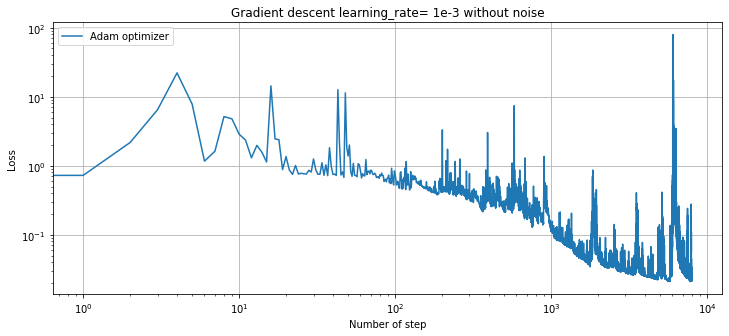

In [102]:
plt.figure(figsize=(12,5))
plt.loglog(ff_with_batch_noise[1],label='Adam optimizer')
plt.xlabel('Number of step')
plt.ylabel('Loss')
plt.title(r'Gradient descent learning_rate= 1e-3 without noise')
plt.legend()
plt.grid()

###  2. Prédiction et observation 

In [80]:
# prediction sur le train set
pred_Adam=predict(ff_with_batch[0],X_Tr)

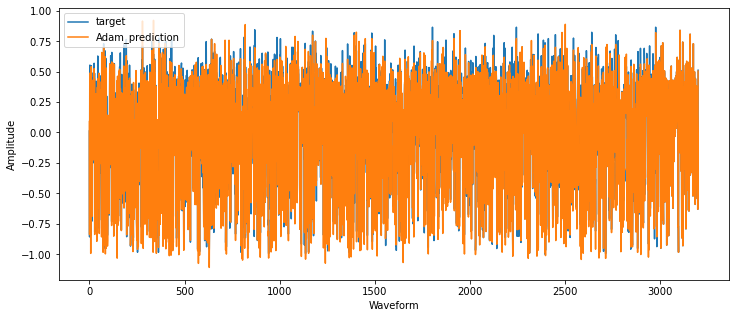

In [81]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred_Adam[:,0],label='Adam_prediction')
plt.ylabel('Amplitude')
plt.xlabel("Waveform")
plt.legend()

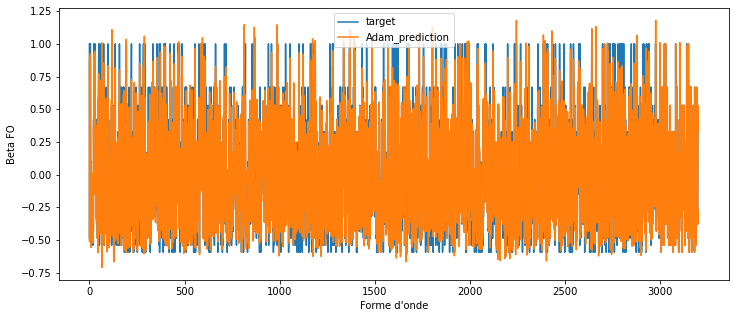

In [82]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred_Adam[:,1],label='Adam_prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.legend()

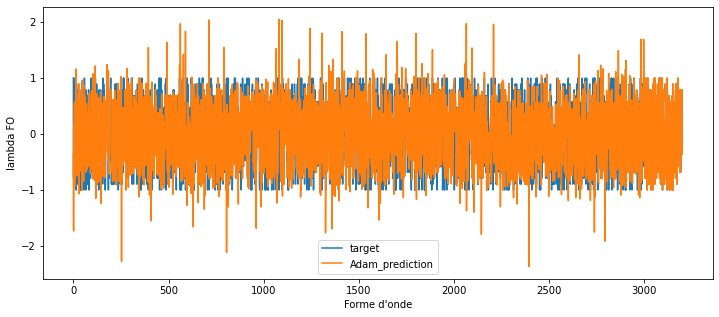

In [83]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,2],label='target')
plt.plot(pred_Adam[:,2],label='Adam_prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.legend()

# IV. Evaluation du modèle

#### Donnée non bruitée

In [84]:
Y_test

array([[ 0.25161392, -0.48597046,  0.57894737],
       [-0.32378632,  0.53052665, -0.05263158],
       [ 0.0805992 , -0.48597046,  0.26315789],
       ...,
       [ 0.26964648,  1.        ,  0.47368421],
       [-0.48620612, -0.15218891, -0.57894737],
       [ 0.57575966,  0.10029942, -0.15789474]])

In [85]:
Y_test[8,1]

-0.5929138877329423

###  1. Remise en forme des paramètres à prédire (signaux physiques)

In [86]:

def real_parameter_prediction(param_test,in_array):
    prediction=predict(param_test[0],in_array)
    Amp_pred=prediction[:,0]*param_test[2][1] + param_test[2][0]
    Bet_pred=prediction[:,1]*param_test[3][1] + param_test[3][0]
    lam_pred=prediction[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(Amp_pred,Bet_pred,lam_pred)])

In [87]:
predT=real_parameter_prediction(ff_with_batch,X_Te)

In [88]:
predT

array([[ 6.2375800e+02,  1.6019782e-01,  1.7413511e+00],
       [ 4.2734027e+02,  1.0537527e+00, -2.8685451e-01],
       [ 5.3678217e+02,  2.4235350e-01,  7.9817039e-01],
       ...,
       [ 6.3581140e+02,  1.4405010e+00,  9.6390957e-01],
       [ 3.5239282e+02,  4.0195793e-01, -1.8403857e+00],
       [ 6.9153436e+02,  7.3360854e-01, -7.8478748e-01]], dtype=float32)

In [89]:
def Y_test_transform(param_test,Y):
    h_real=Y[:,0]*param_test[2][1] + param_test[2][0]
    b_real=Y[:,1]*param_test[3][1] + param_test[3][0]
    l_real=Y[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(h_real,b_real,l_real)])

In [90]:
Y_TT=Y_test_transform(ff_with_batch,Y_test)

In [91]:
mse_loss(ff_with_batch[0], X_Te, Y_TT)

DeviceArray(311761.1, dtype=float32)

###  2. Visualisation des prédictions sur les trois paramètres

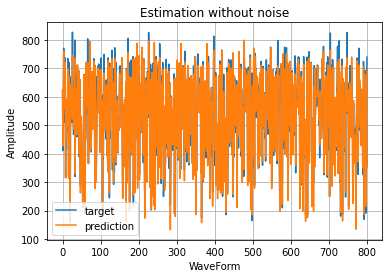

In [92]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,0],label='target')
plt.plot(predT[:,0],label='prediction')
plt.ylabel('Amplitude')
plt.xlabel("WaveForm")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

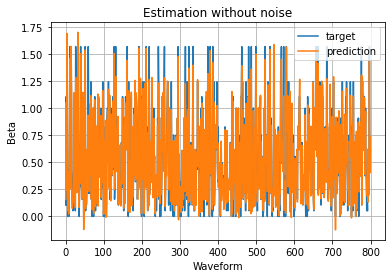

In [93]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,1],label='target')
plt.plot(predT[:,1],label='prediction')
plt.ylabel('Beta')
plt.xlabel("Waveform")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

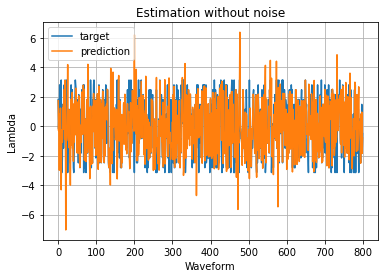

In [94]:
#plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,2],label='target')
plt.plot(predT[:,2],label='prediction')
plt.ylabel('Lambda')
plt.xlabel("Waveform")
plt.title('Estimation without noise')
plt.grid()
plt.legend()

###  3. Histogramme des erreurs de prediction sur le Test_Set 

In [95]:
def LOSS_Hist(params,in_array,targets):
    preds=real_parameter_prediction(params,in_array)
    a_error =(preds[:,0]-targets[:,0])/(targets[:,0])
    b_error =(preds[:,1]-targets[:,1])/(targets[:,1]+1e-1)
    l_error =(preds[:,2]-targets[:,2])/(targets[:,2]+1e-15)
    return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)

In [96]:
a_err,b_err,l_err=LOSS_Hist(ff_with_batch,X_Te,Y_TT)

<ipython-input-95-1a72e282eaba>:6: RuntimeWarning: invalid value encountered in log10
  return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)


Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set")

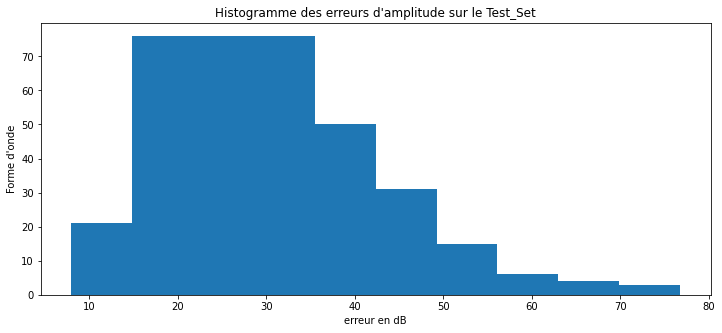

In [296]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set')


Text(0.5, 1.0, 'Histogramme des erreurs du paramètre beta sur le Test_Set')

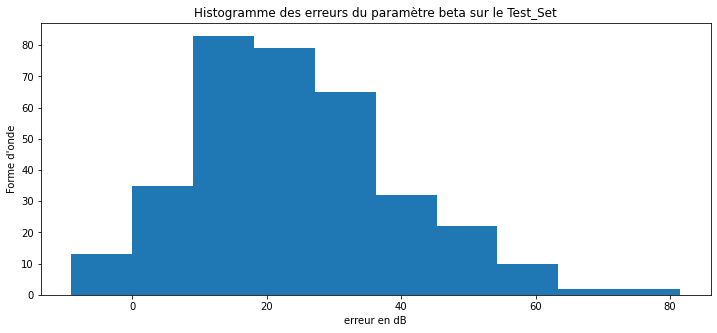

In [297]:
plt.figure(figsize=(12,5))
plt.hist(np.array(b_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre beta sur le Test_Set')

Text(0.5, 1.0, 'Histogramme des erreurs du paramètre lambda sur le Test_Set')

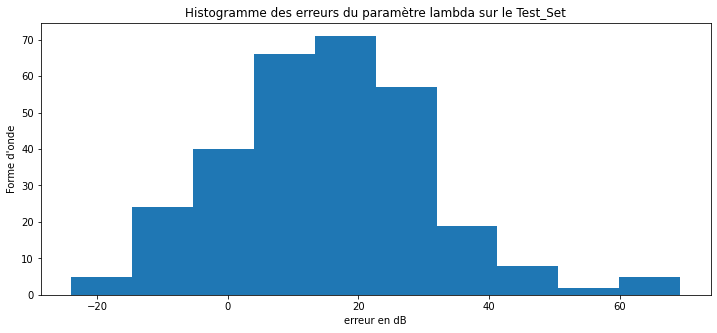

In [298]:
plt.figure(figsize=(12,5))
plt.hist(np.array(l_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre lambda sur le Test_Set')

Text(0, 0.5, "Forme d'onde")

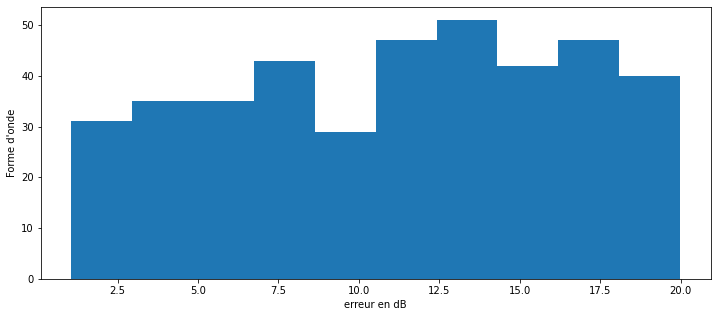

In [178]:
plt.figure(figsize=(12,5))
plt.hist(X[:,0])
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')

#### Donnée bruitée

In [103]:
predT_noise=real_parameter_prediction(ff_with_batch_noise,X_Te_n)

In [104]:
predT_noise

array([[ 5.4653418e+02,  2.1784878e-01,  1.6551706e+00],
       [ 5.6418652e+02,  8.9800906e-01, -1.3522415e-01],
       [ 5.0878131e+02,  2.7420744e-01,  8.8024080e-01],
       ...,
       [ 7.4177557e+02,  1.0916555e+00, -2.2585981e-02],
       [ 3.5843591e+02,  3.6828297e-01, -1.8822012e+00],
       [ 5.3573932e+02,  7.0004165e-01,  2.8306019e-01]], dtype=float32)

In [105]:
Y_TT_noise=Y_test_transform(ff_with_batch_noise,Y_test)

In [106]:
mse_loss(ff_with_batch_noise[0], X_Te_n, Y_TT_noise)

DeviceArray(311794.44, dtype=float32)

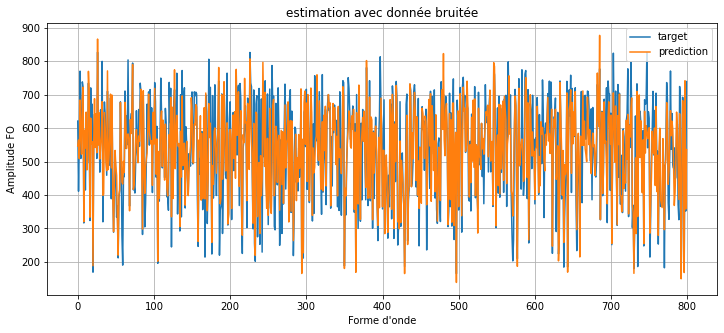

In [107]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_noise[:,0],label='target')
plt.plot(predT_noise[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('estimation avec donnée bruitée')
plt.grid()
plt.legend()

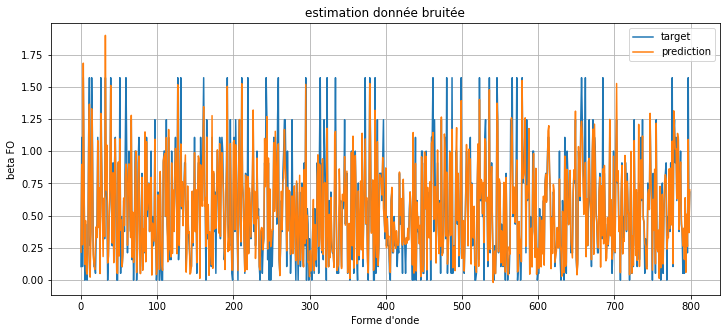

In [108]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT_noise[:,1],label='target')
plt.plot(predT_noise[:,1],label='prediction')
plt.ylabel('beta FO')
plt.xlabel("Forme d'onde")
plt.title('estimation donnée bruitée')
plt.grid()
plt.legend()

In [109]:
a_err_n,b_err_n,l_err_n=LOSS_Hist(ff_with_batch_noise,X_Te_n,Y_TT_noise)

<ipython-input-95-1a72e282eaba>:6: RuntimeWarning: invalid value encountered in log10
  return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)


Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set avec donnée bruitée")

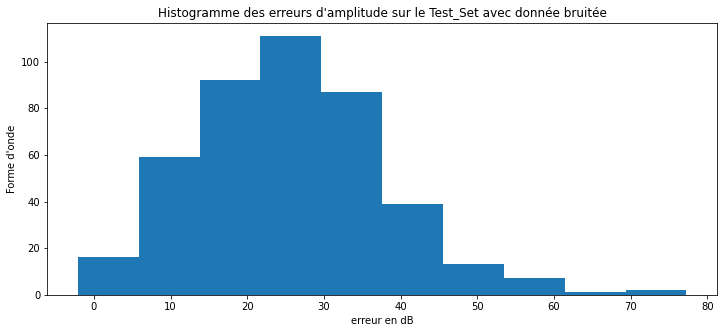

In [110]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err_n))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set avec donnée bruitée')



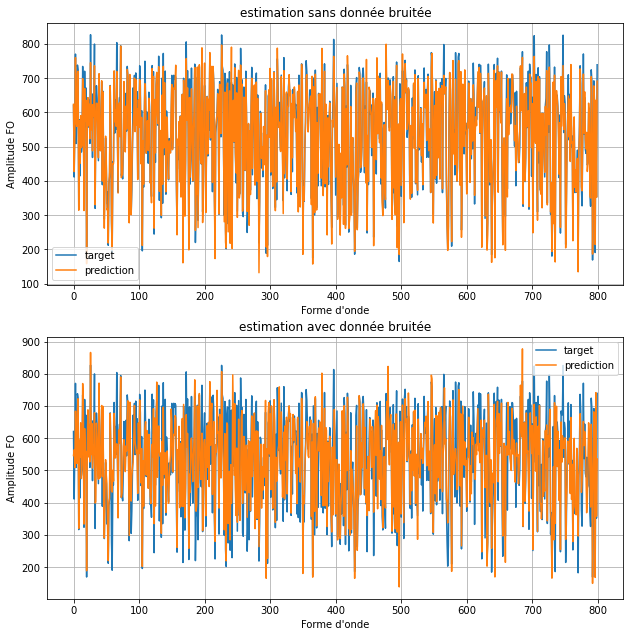

In [111]:
figure = plt.figure(figsize = (20, 20))
plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,
                       right = 0.7, top = 0.7, wspace = 0, hspace = 0.2)
axes = figure.add_subplot(2, 1, 1)
axes.set_xlabel("Forme d'onde")
axes.set_ylabel('Amplitude FO')
axes.set_title('estimation sans donnée bruitée')
axes.plot(Y_TT[:,0],label='target')
axes.plot(predT[:,0],label='prediction')
plt.grid()
plt.legend()

axes = figure.add_subplot(2, 1, 2)
axes.set_xlabel("Forme d'onde")
axes.set_ylabel('Amplitude FO')
axes.set_title('estimation avec donnée bruitée')
axes.plot(Y_TT_noise[:,0],label='target')
axes.plot(predT_noise[:,0],label='prediction')
plt.grid()
plt.legend()

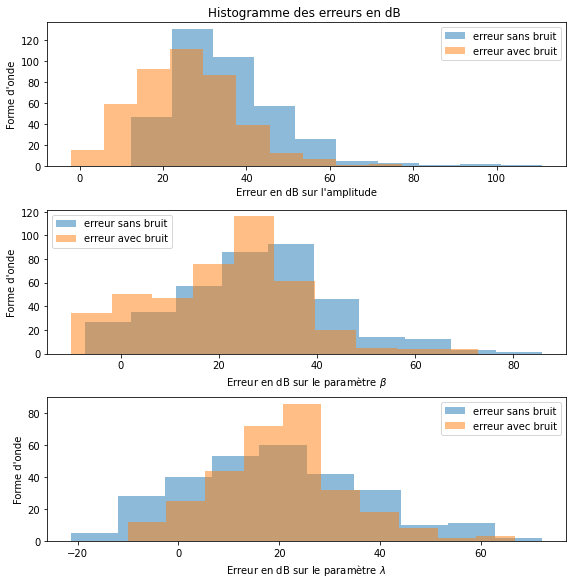

In [112]:
figure = plt.figure(figsize = (18, 18))
plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,
                       right = 0.7, top = 0.7, wspace = 0.2, hspace = 0.3)
axes = figure.add_subplot(3, 1, 1)
plt.hist(a_err, bins=10, alpha=0.5, label='erreur sans bruit') 
plt.hist(a_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper right')
plt.title("Histogramme des erreurs en dB ")
plt.xlabel('Erreur en dB sur l\'amplitude')
plt.ylabel('Forme d\'onde')

axes = figure.add_subplot(3, 1, 2)
plt.hist(b_err, bins=10, alpha=0.5, label='erreur sans bruit') 
plt.hist(b_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper left')
plt.xlabel(r"Erreur en dB sur le paramètre $\beta$")
plt.ylabel('Forme d\'onde')

axes = figure.add_subplot(3, 1, 3)
plt.hist(l_err, bins=10,alpha=0.5, label='erreur sans bruit') 
plt.hist(l_err_n, bins=10, alpha=0.5, label='erreur avec bruit') 
plt.legend(loc='upper right')
plt.xlabel(r'Erreur en dB sur le paramètre $\lambda$' )
plt.ylabel('Forme d\'onde')


#plt.savefig("Histo_error.png", bbox_inches='tight')
plt.show()




In [223]:
x=np.array([[2,3,4],[5,6,7]])
x.ndim

2

In [224]:
plt.savefig("Histo_error.png", bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

In [111]:
np.array(a_err).shape

(400,)

Text(0, 0.5, "Forme d'onde")

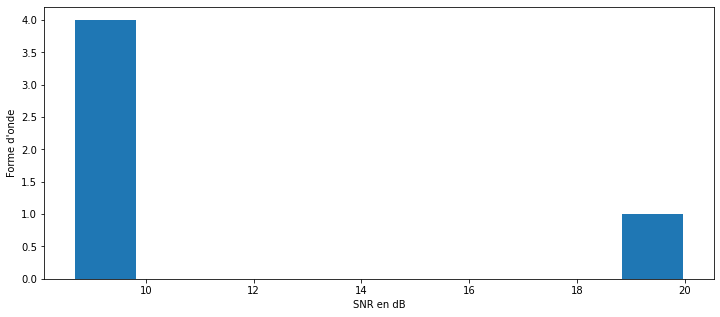

In [116]:
plt.figure(figsize=(12,5))
out=plt.hist(X[0,:])
plt.xlabel('SNR en dB')
plt.ylabel('Forme d\'onde')




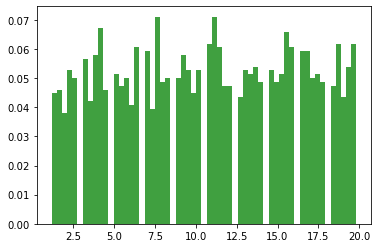

In [117]:
n, bins, patches = plt.hist(X, density=True, facecolor='g', alpha=0.75)

<BarContainer object of 400 artists>

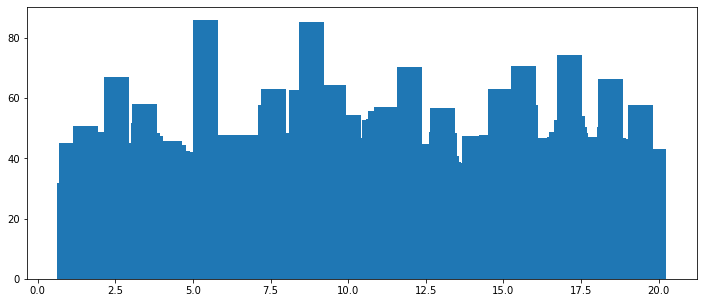

In [121]:
plt.figure(figsize=(12,5))
plt.bar(X[:,0],a_err)

<BarContainer object of 400 artists>

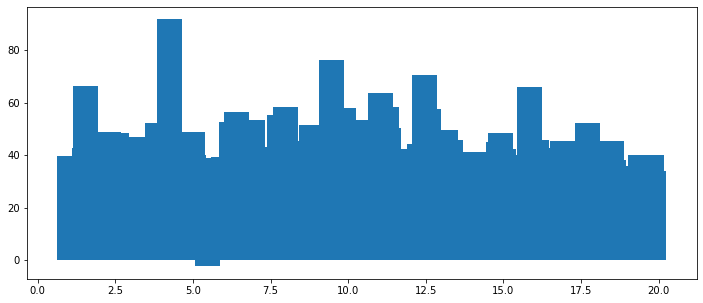

In [122]:
plt.figure(figsize=(12,5))
plt.bar(X[:,0],b_err)